Этапы исследования:

1) Визуализация данных

2) Обработка выбросов

3...

4...

5) Обучение различных моделей

6) Тестирование подхода с анализом новостей

7) Сравнение моделей и метрик

8) Подготовка дообучения моделей для приложения

Установка необходимых библиотек

In [8]:
! pip install -r ../requirements.txt

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 762.0 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/9.8 MB 762.0 kB/s eta 0:00:13
   --- ------------------------------------ 0.8/9.8 MB 799.2 kB/s eta 0:00:12
   ---- ----------------------------------- 1.0/9.8 MB 853.0 kB/s eta 0:00:11
   ----- ---------------------------------- 1.3/9.8 MB 894.7 kB/s eta 0:00:10
   ------ --------------------------------- 1.6/9.8 MB 921.7 kB/s eta 0:00:09
   ------- -------------------------------- 1.8/9.8 MB 967.9 kB/s eta 0:00:09
   -------- ------------------------------- 2.1/9.8 MB 995.1 kB/s eta 0:00:08
   --------- ------------------------------ 2.4/9.8 MB 1.0 MB/s eta 0:00:08
   ---------- ----------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортирование необходимых библиотек

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpdates
import numpy as np
import statsmodels.api as sm
from scipy import stats


import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit



## Анализ данных

Откроем наши данные

In [10]:
moex_data = pd.read_parquet('../data/moex.parquet')
moex_data.head()

,company,open,close,begin,end
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59


Визуализируем наши данные

In [11]:
moex_data['begin'] = pd.to_datetime(moex_data['begin'])
moex_data['end'] = pd.to_datetime(moex_data['end'])
moex_data['target'] = moex_data['close'] - moex_data['open']
moex_data['date'] = moex_data['begin'].dt.date

companies = moex_data['company'].unique()

plt.style.use('seaborn-v0_8-whitegrid')

In [12]:
moex_data

,company,open,close,begin,end,target,date
0,SBER,141.60,141.60,2023-01-03 09:00:00,2023-01-03 09:59:59,0.00,2023-01-03
1,SBER,141.60,142.66,2023-01-03 10:00:00,2023-01-03 10:59:59,1.06,2023-01-03
2,SBER,142.66,142.42,2023-01-03 11:00:00,2023-01-03 11:59:59,-0.24,2023-01-03
3,SBER,142.43,141.91,2023-01-03 12:00:00,2023-01-03 12:59:59,-0.52,2023-01-03
4,SBER,141.91,141.67,2023-01-03 13:00:00,2023-01-03 13:59:59,-0.24,2023-01-03
...,...,...,...,...,...,...,...
49534,T,3212.80,3229.80,2025-02-28 16:00:00,2025-02-28 16:59:59,17.00,2025-02-28
49535,T,3229.80,3245.80,2025-02-28 17:00:00,2025-02-28 17:59:59,16.00,2025-02-28
49536,T,3245.20,3274.00,2025-02-28 18:00:00,2025-02-28 18:59:59,28.80,2025-02-28
49537,T,3274.00,3284.00,2025-02-28 19:00:00,2025-02-28 19:59:59,10.00,2025-02-28


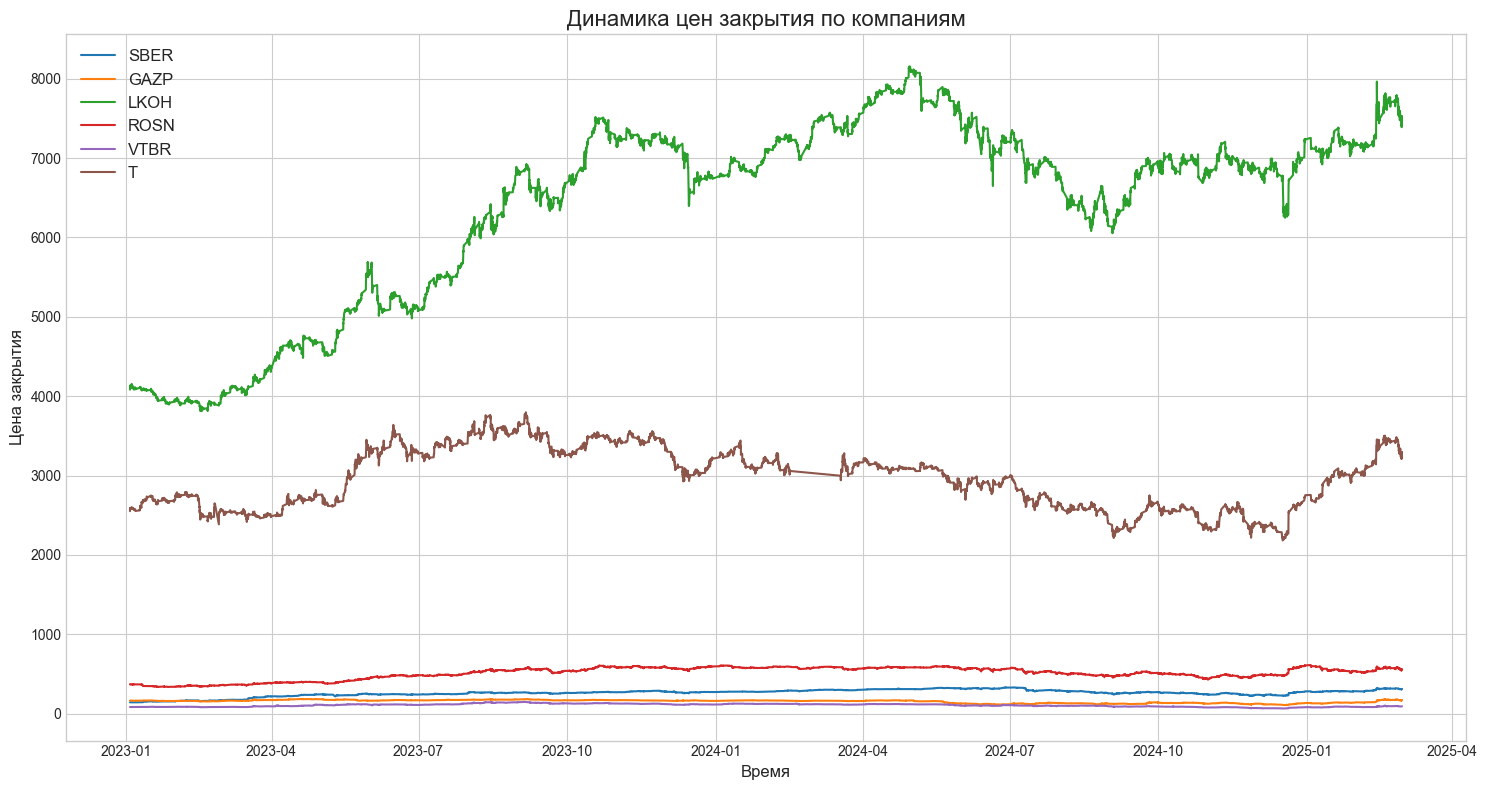

In [13]:
plt.figure(figsize=(15, 8))
for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    plt.plot(company_data['begin'], company_data['close'], label=company)

plt.title('Динамика цен закрытия по компаниям', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Цена закрытия', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Свечи для каждой из компаний

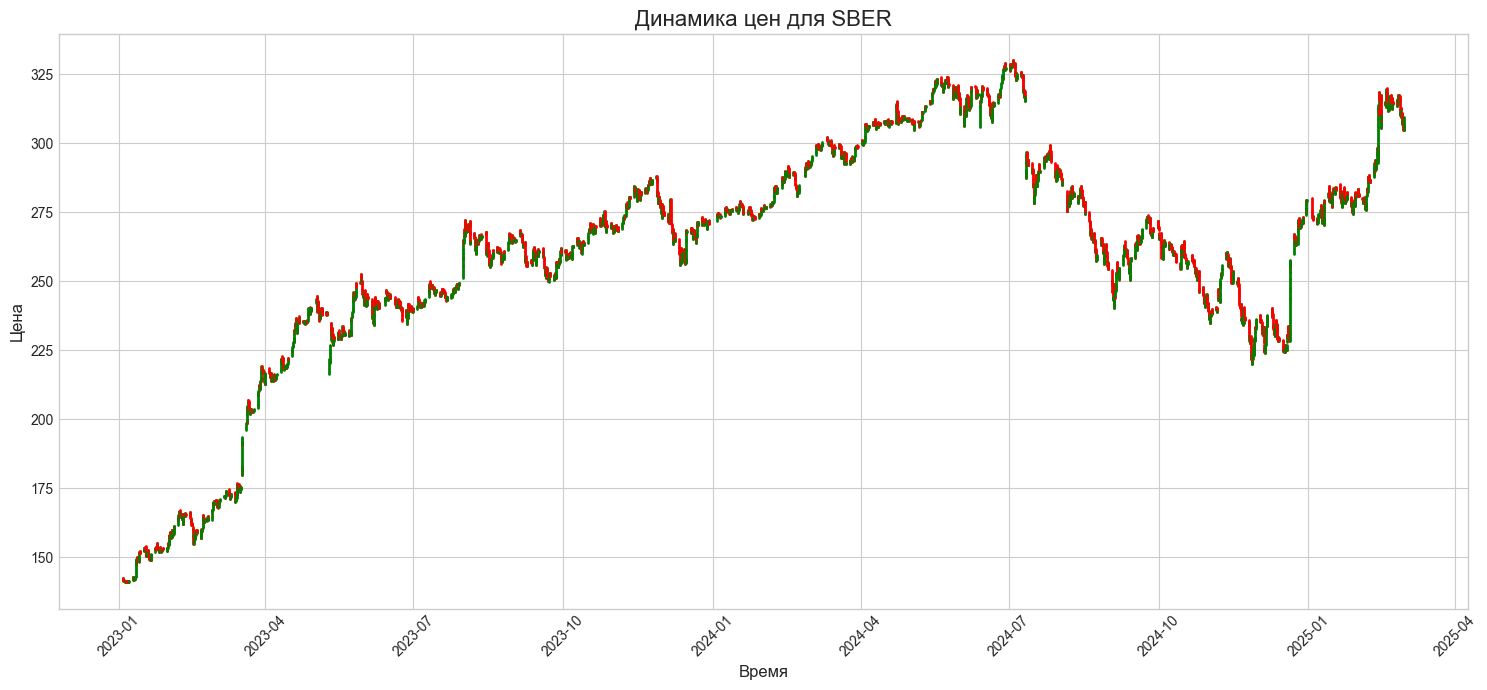

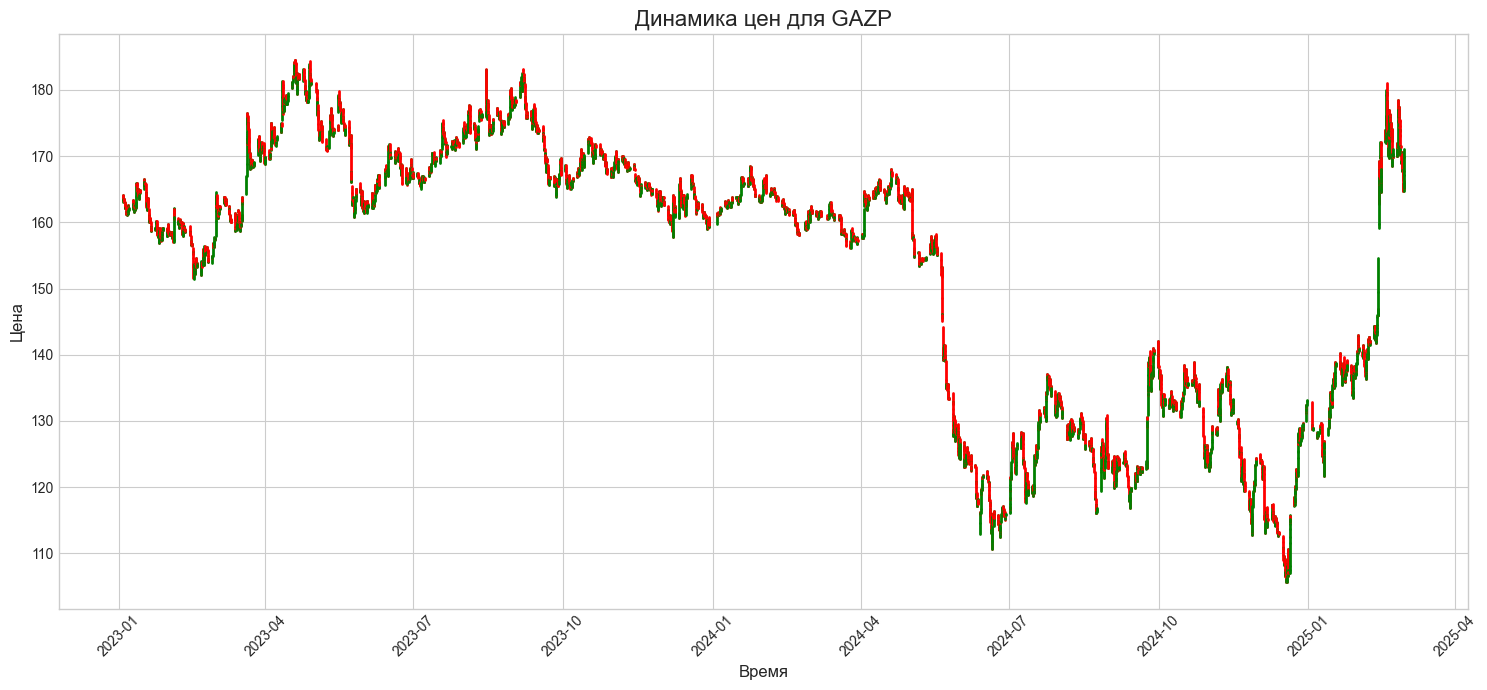

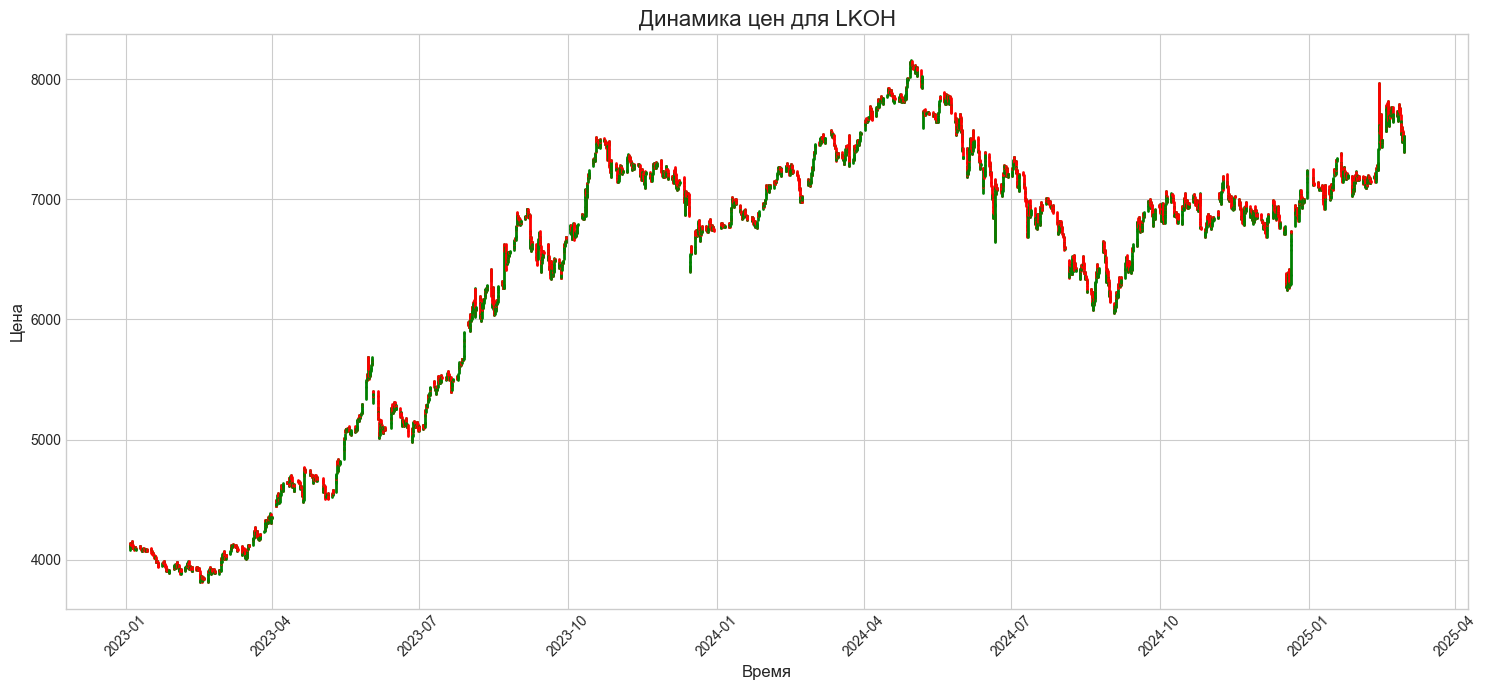

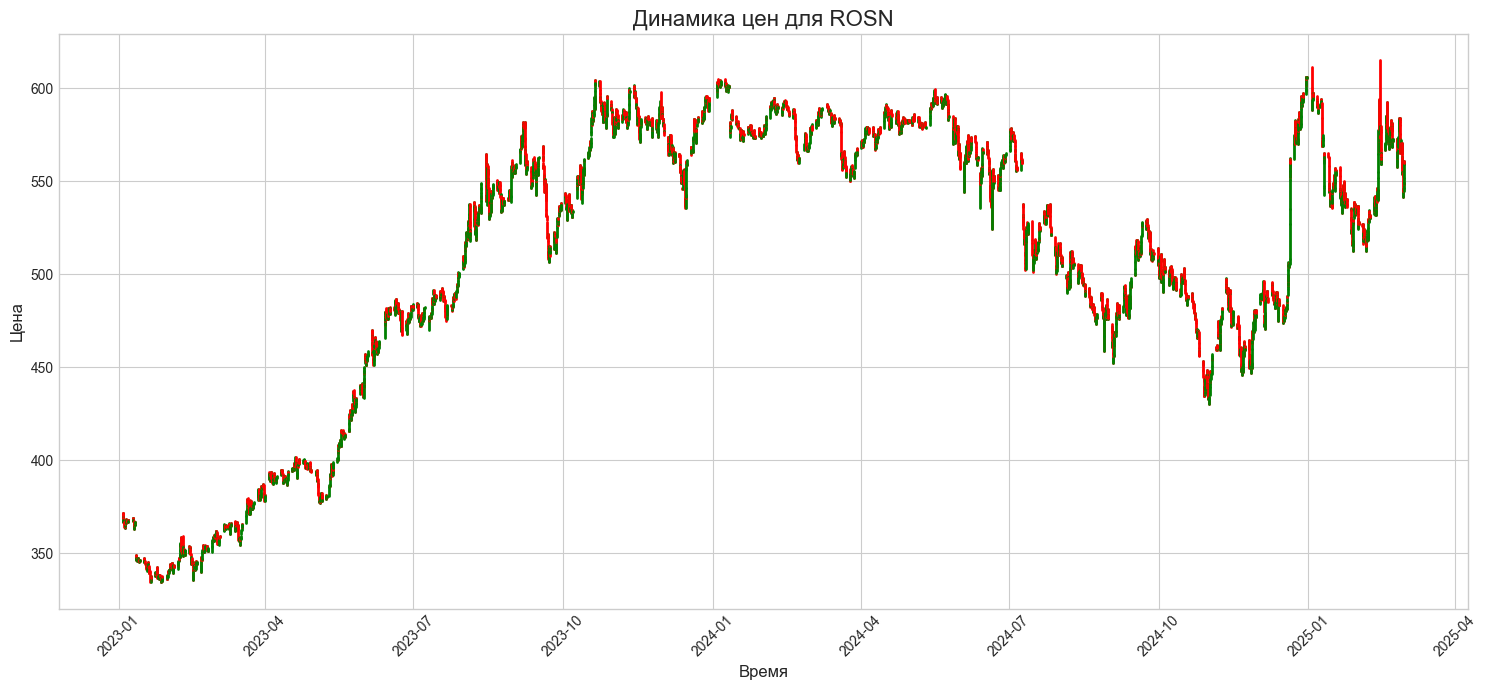

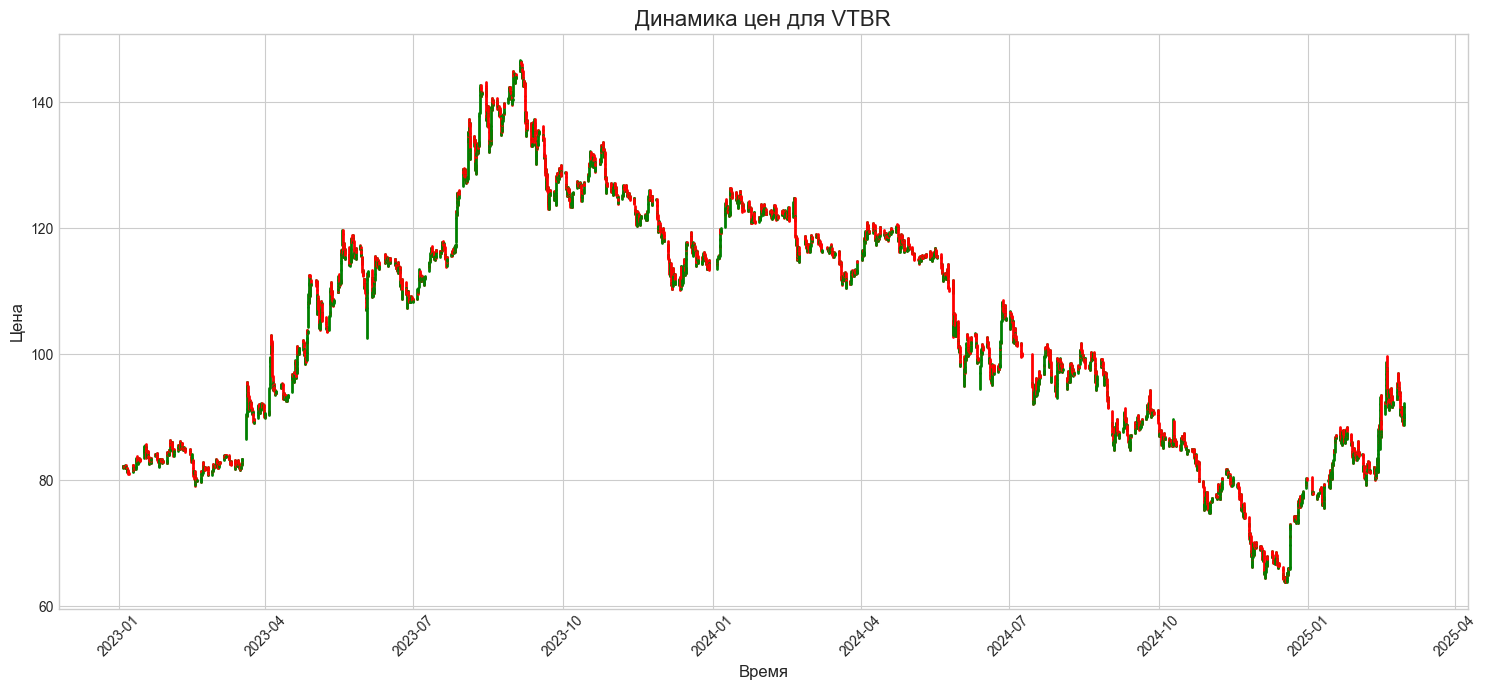

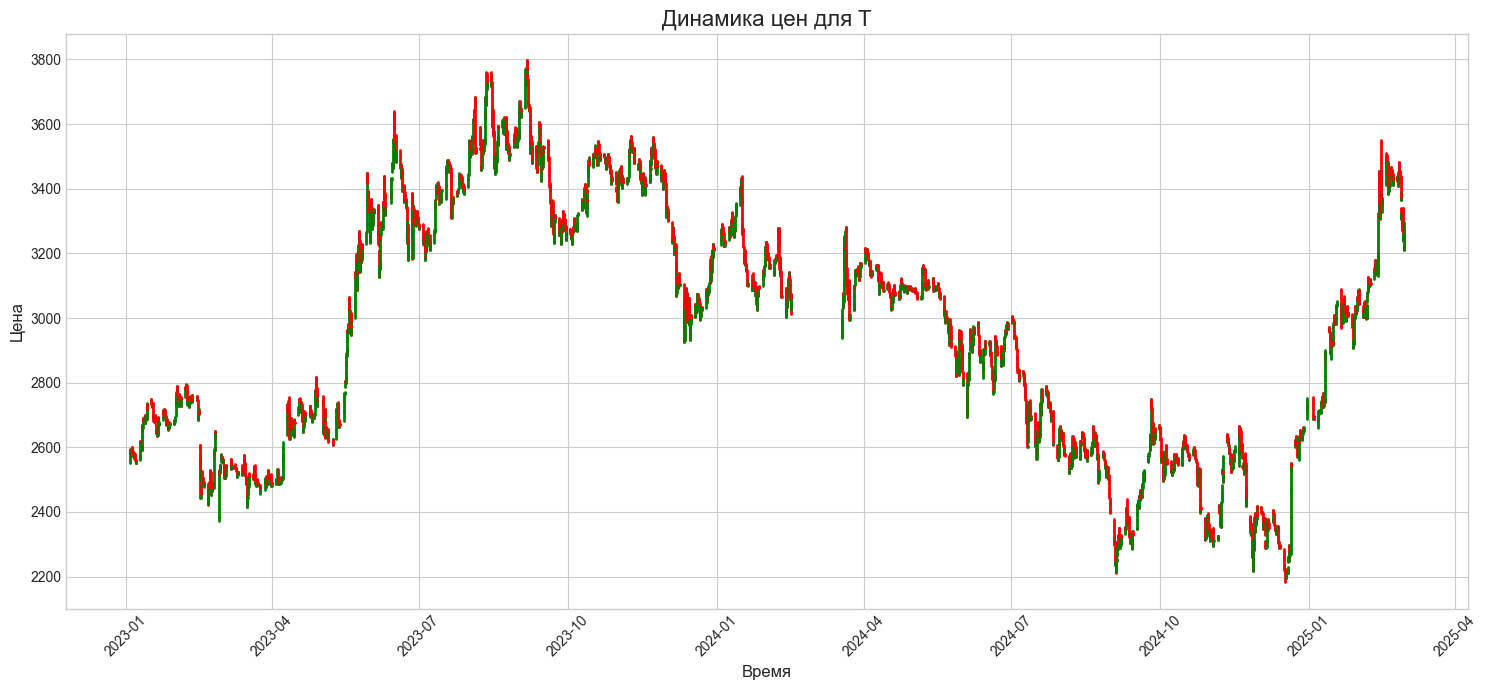

In [14]:
for company in companies:
    company_data = moex_data[moex_data['company'] == company].copy()
    
    fig, ax = plt.subplots(figsize=(15, 7))
    
    for i in range(len(company_data)):
        row = company_data.iloc[i]
        x = row['begin']
        open_price = row['open']
        close_price = row['close']
        
        color = 'green' if close_price >= open_price else 'red'
        
        ax.plot([x, x], [open_price, close_price], color=color, linewidth=2)
    
    ax.set_title(f'Динамика цен для {company}', fontsize=16)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Цена', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Нарисуем графики скользящего среднего для каждой из компании 

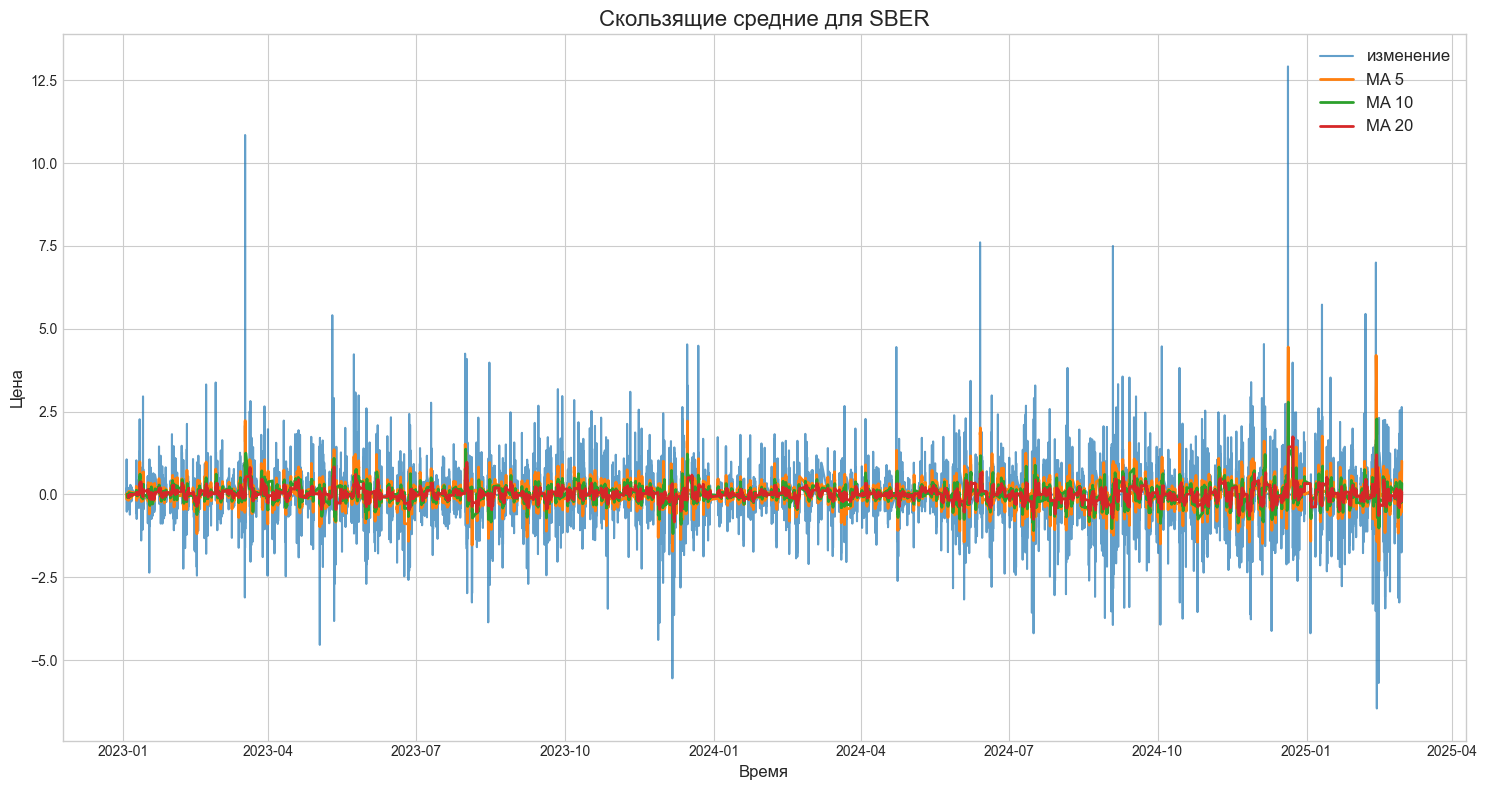

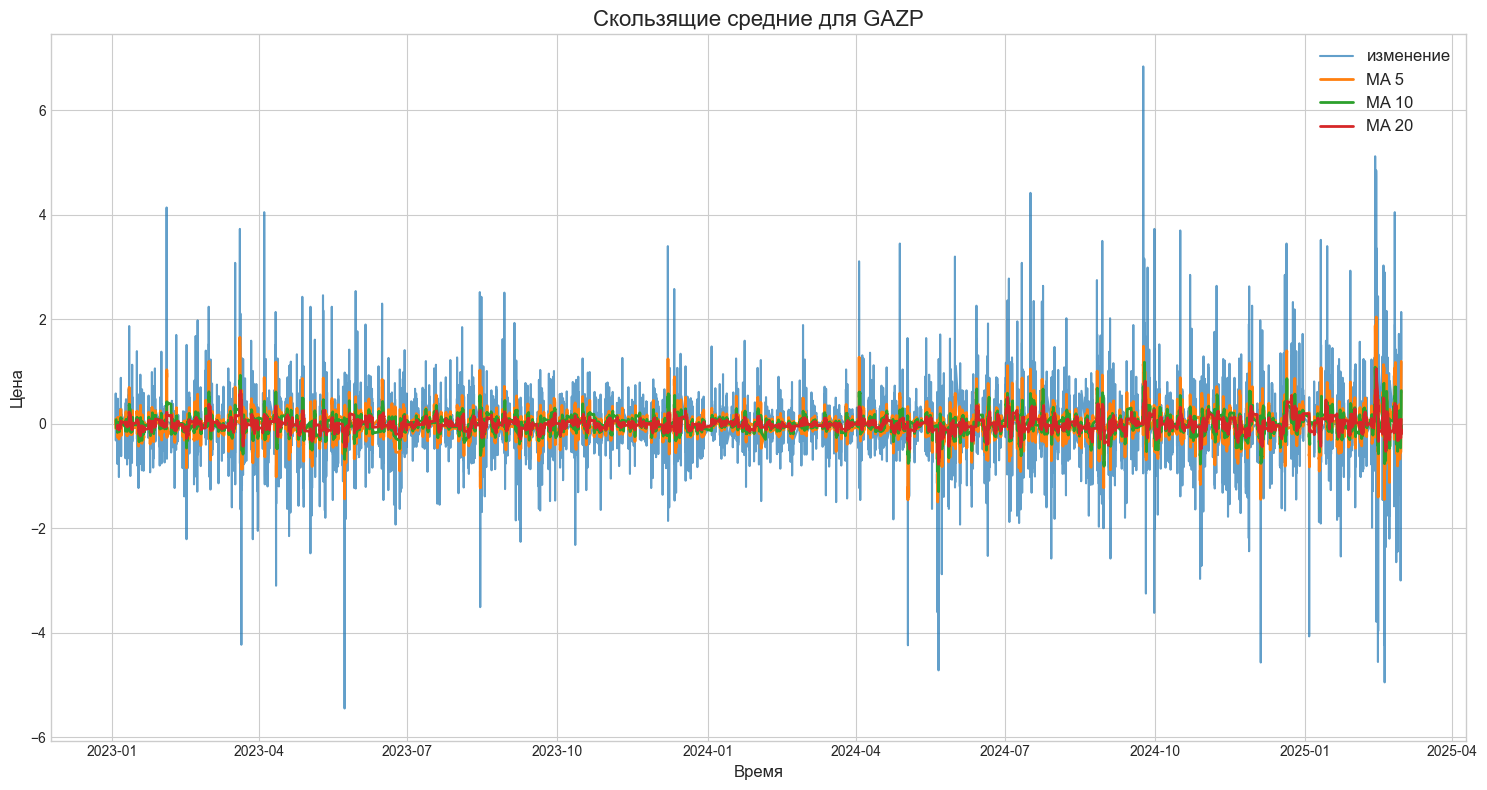

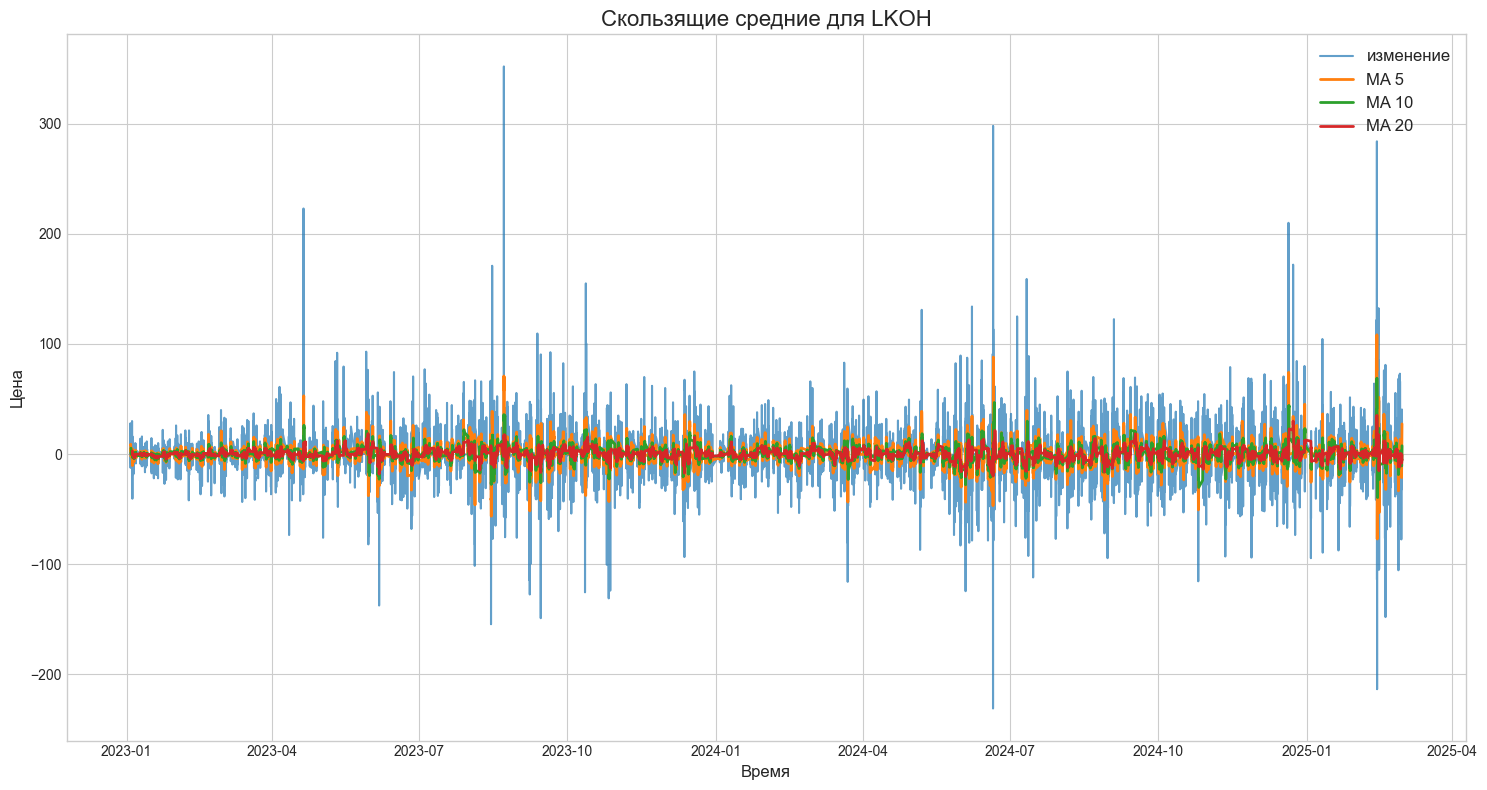

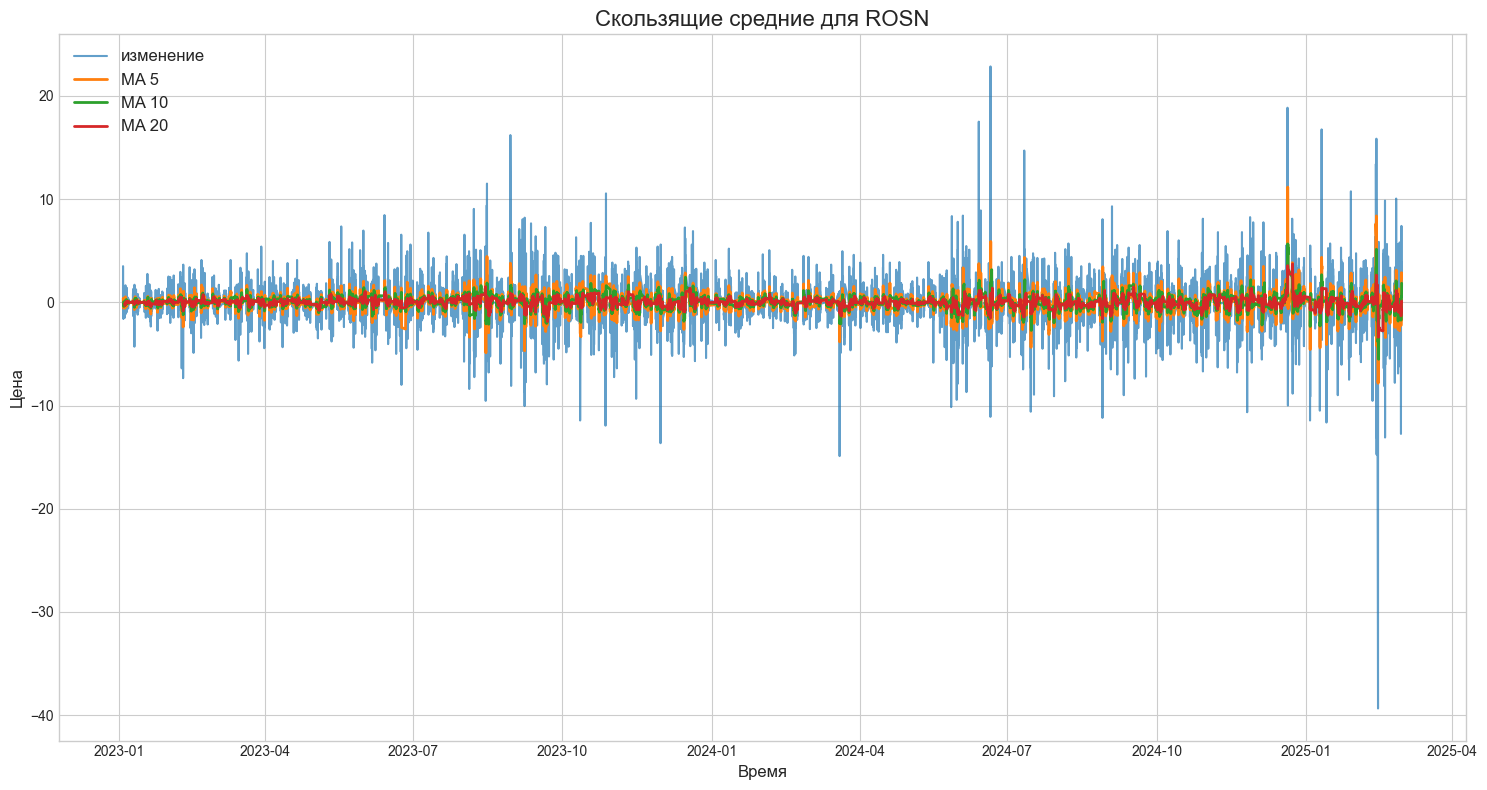

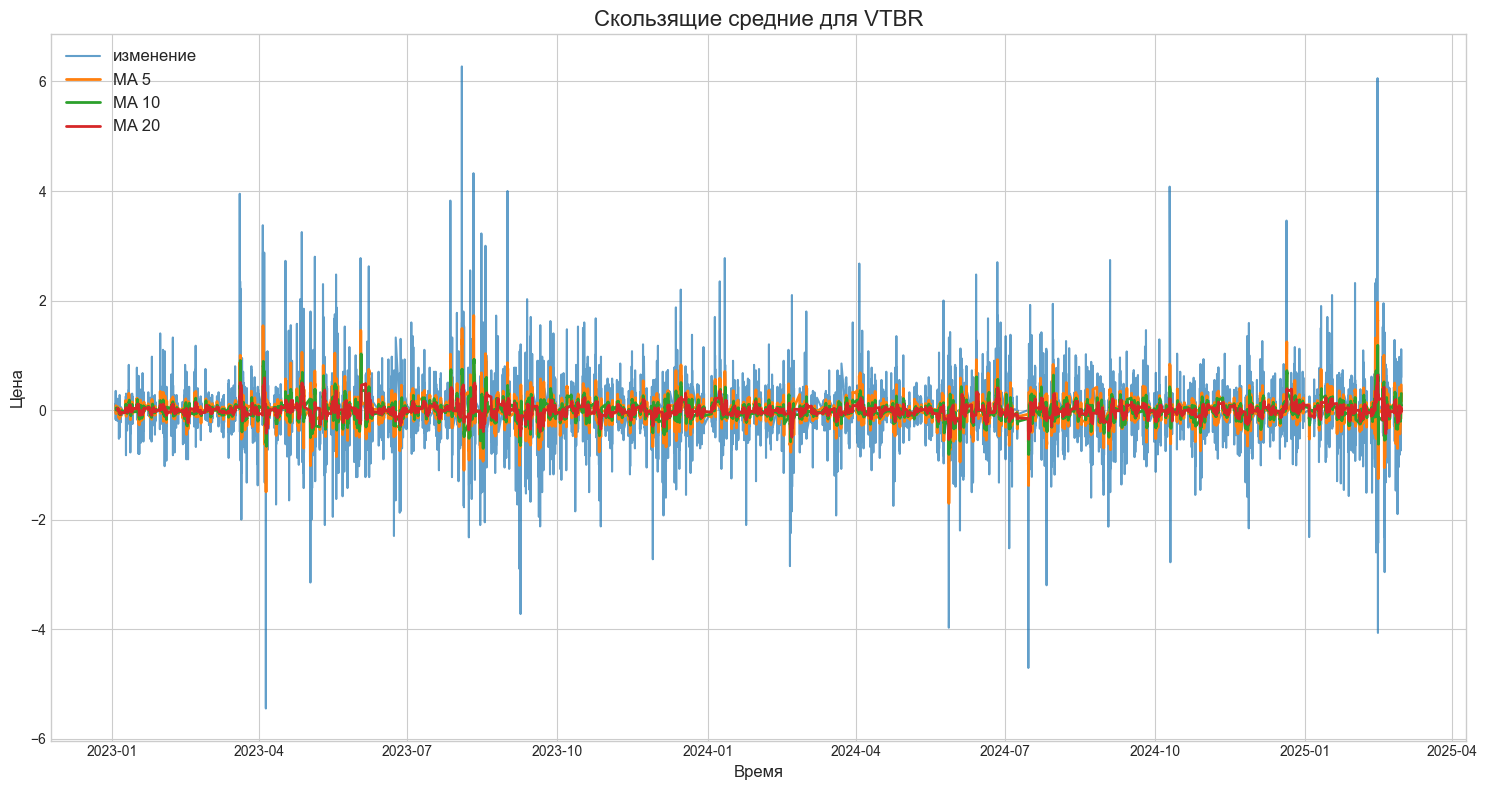

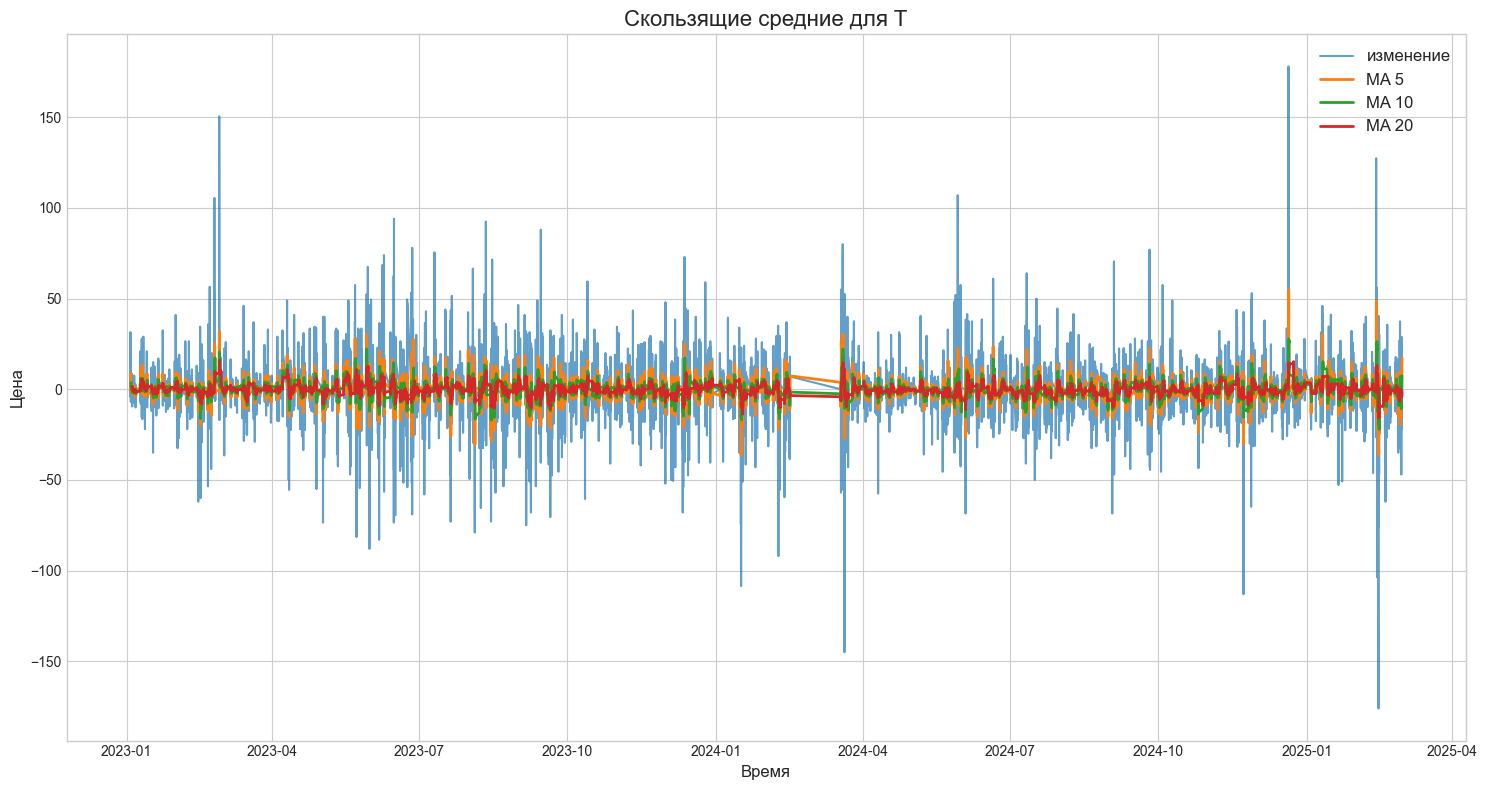

In [15]:
for company in companies:
    company_data = moex_data[moex_data['company'] == company].copy()
    
    closes = company_data['target'].values
    
    ma5 = []
    ma10 = []
    ma20 = []
    
    for i in range(len(closes)):
        if i >= 4: 
            ma5.append(sum(closes[i-4:i+1])/5)
        else:
            ma5.append(None)
            
        if i >= 9:  
            ma10.append(sum(closes[i-9:i+1])/10)
        else:
            ma10.append(None)
            
        if i >= 19:  
            ma20.append(sum(closes[i-19:i+1])/20)
        else:
            ma20.append(None)
    
    company_data['MA_5'] = ma5
    company_data['MA_10'] = ma10
    company_data['MA_20'] = ma20
    
    plt.figure(figsize=(15, 8))
    plt.plot(company_data['begin'], company_data['target'], label='изменение', alpha=0.7)
    plt.plot(company_data['begin'], company_data['MA_5'], label='MA 5', linewidth=2)
    plt.plot(company_data['begin'], company_data['MA_10'], label='MA 10', linewidth=2)
    plt.plot(company_data['begin'], company_data['MA_20'], label='MA 20', linewidth=2)
    
    plt.title(f'Скользящие средние для {company}', fontsize=16)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Цена', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Выбранная нами гранулярность - 1 час

Сезонности здесь нет

Но акции коррелируют между собой, что показывает однородность изменчивости рынка

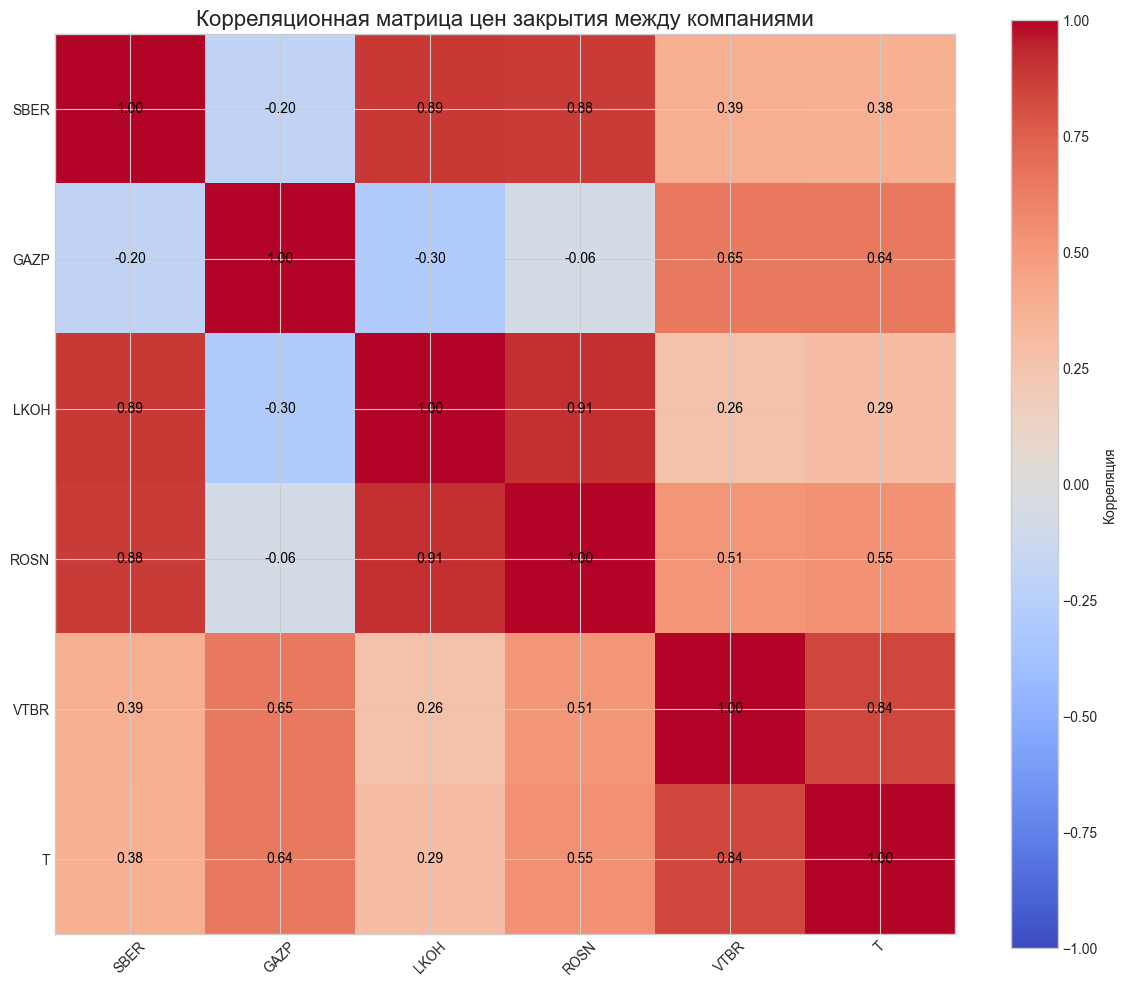

In [16]:
pivot_data = []
for timestamp in moex_data['begin'].unique():
    row = {'timestamp': timestamp}
    for company in companies:
        company_data = moex_data[(moex_data['company'] == company) & (moex_data['begin'] == timestamp)]
        if not company_data.empty:
            row[company] = company_data['close'].values[0]
    pivot_data.append(row)

pivot_df = pd.DataFrame(pivot_data).set_index('timestamp')

corr_matrix = pivot_df.corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Корреляция')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black')

plt.title('Корреляционная матрица цен закрытия между компаниями', fontsize=16)
plt.tight_layout()
plt.show()

На графике выше наблюдается сильная корреляция

Посмотрим автокорреляцию для каждого из временных рядов

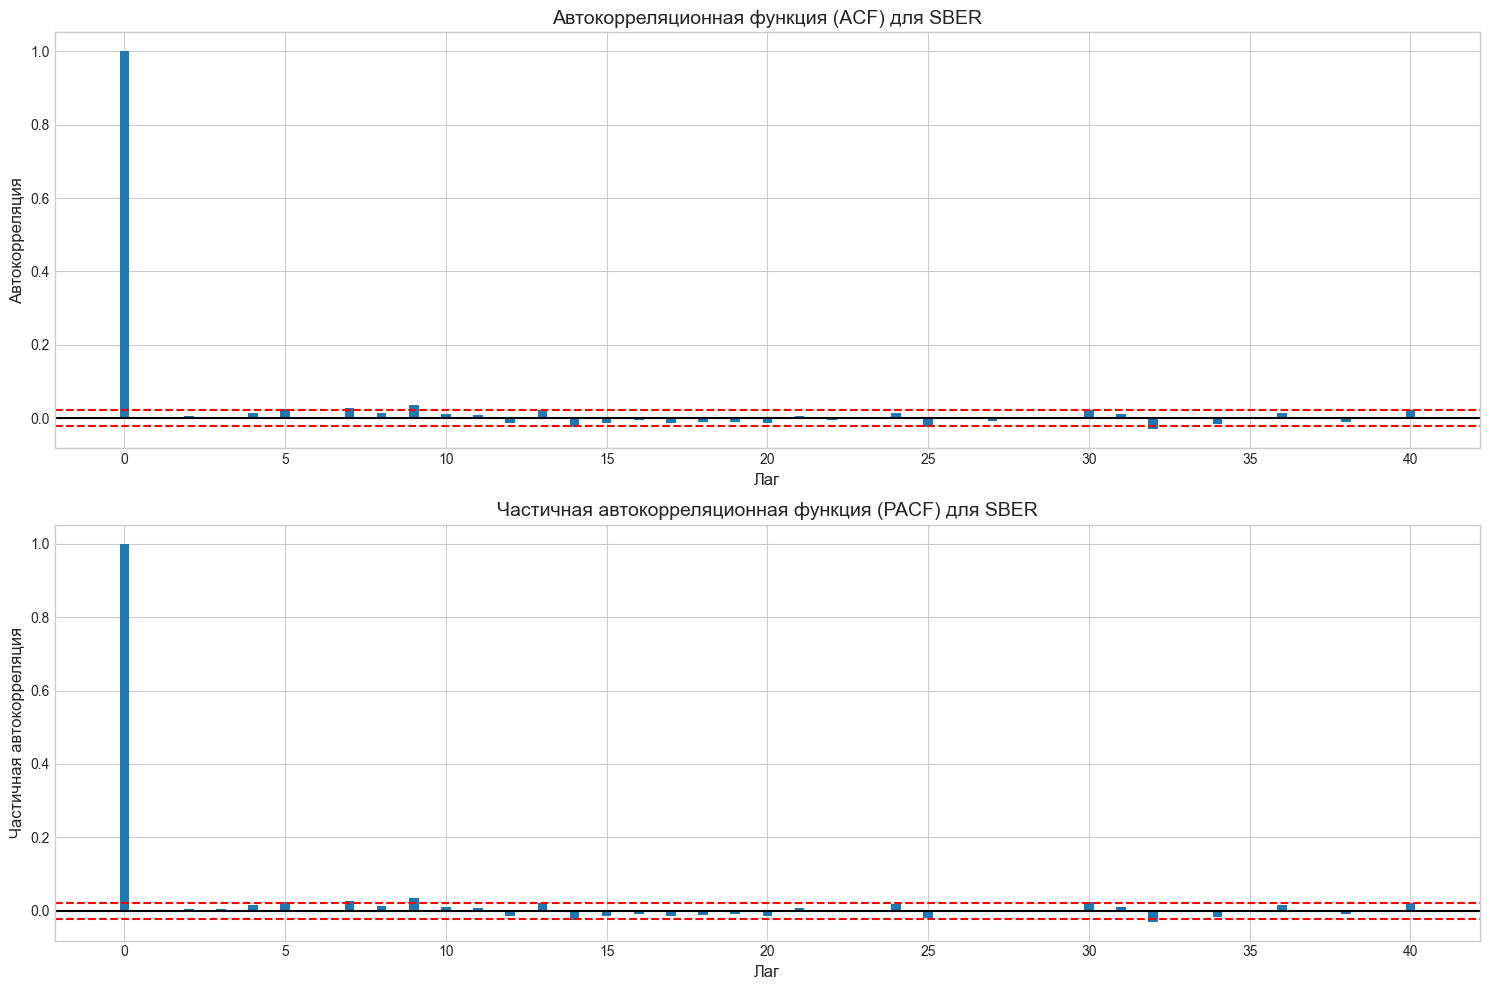

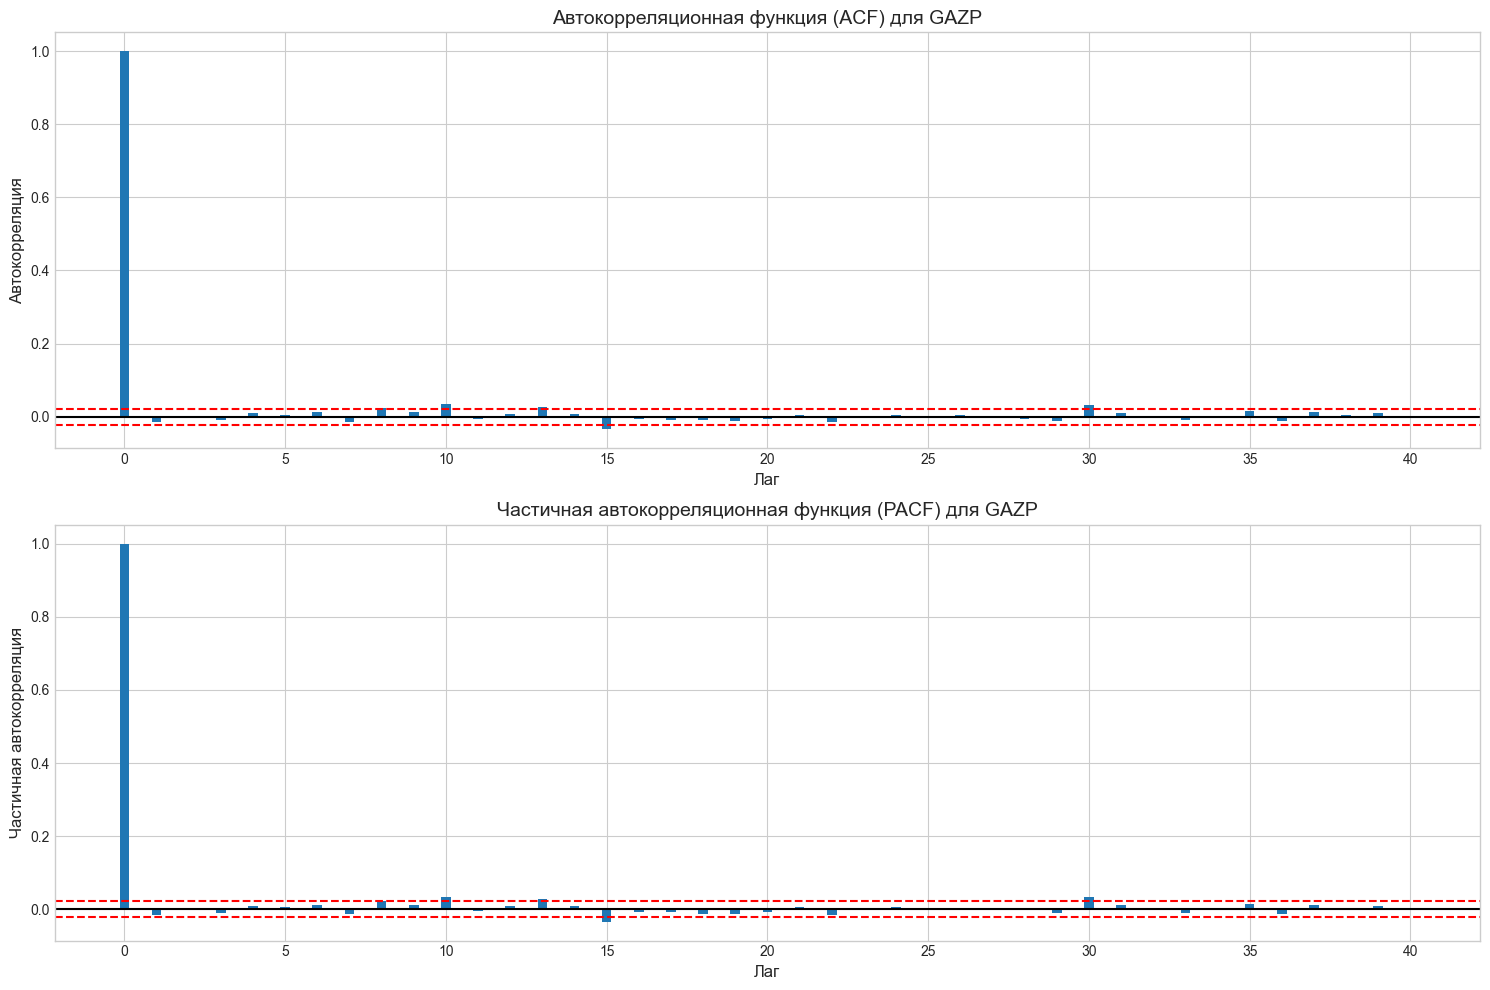

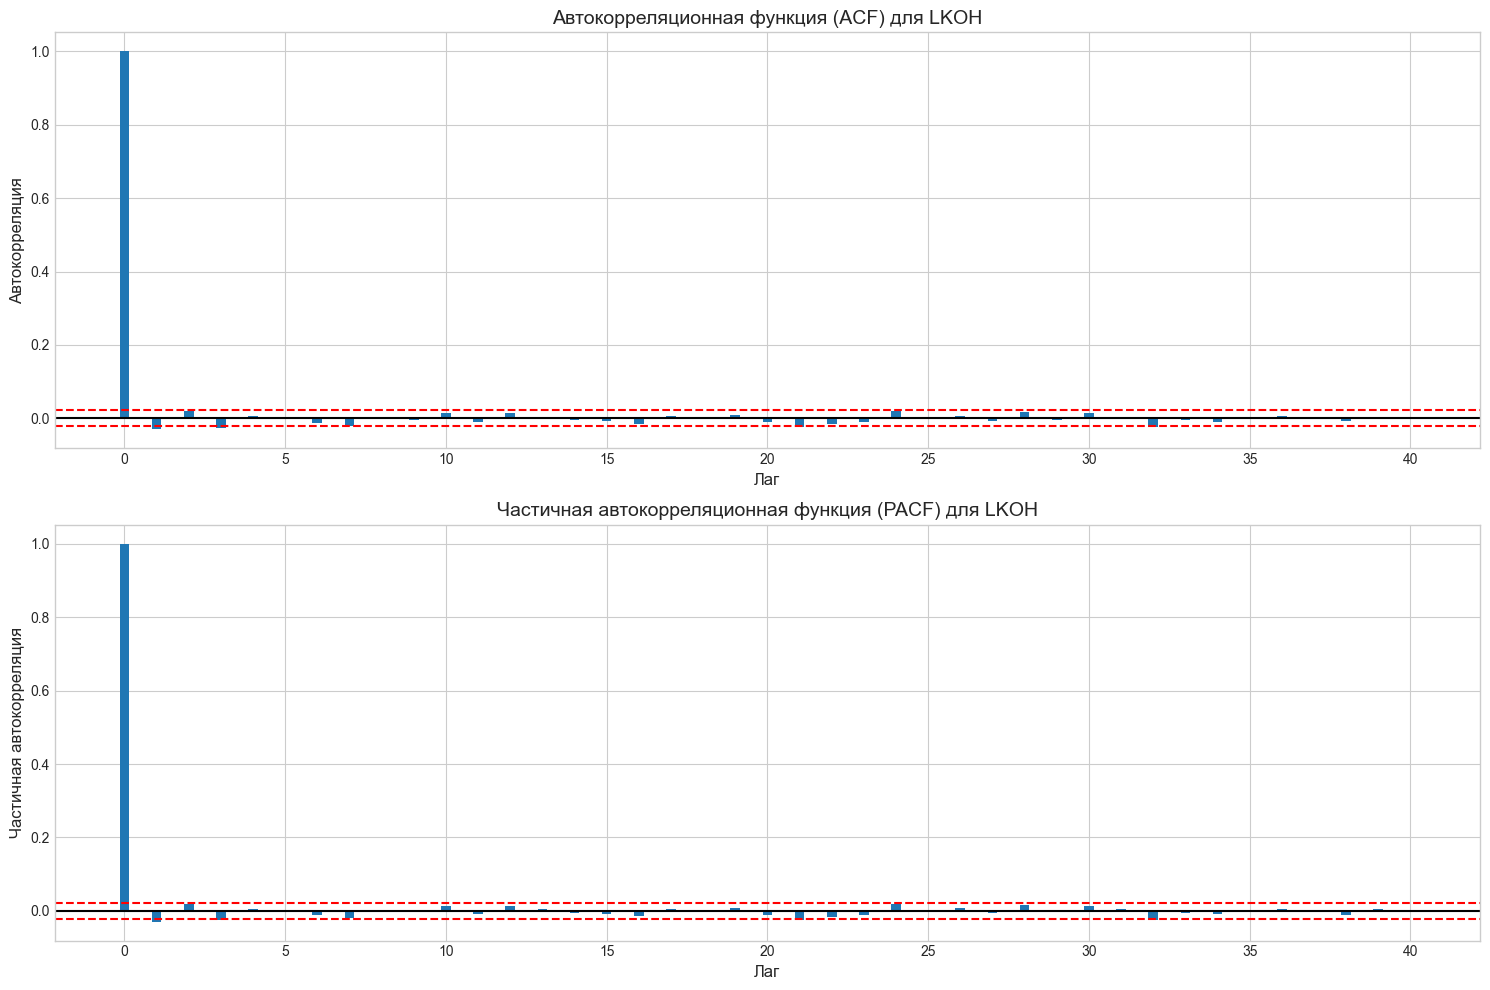

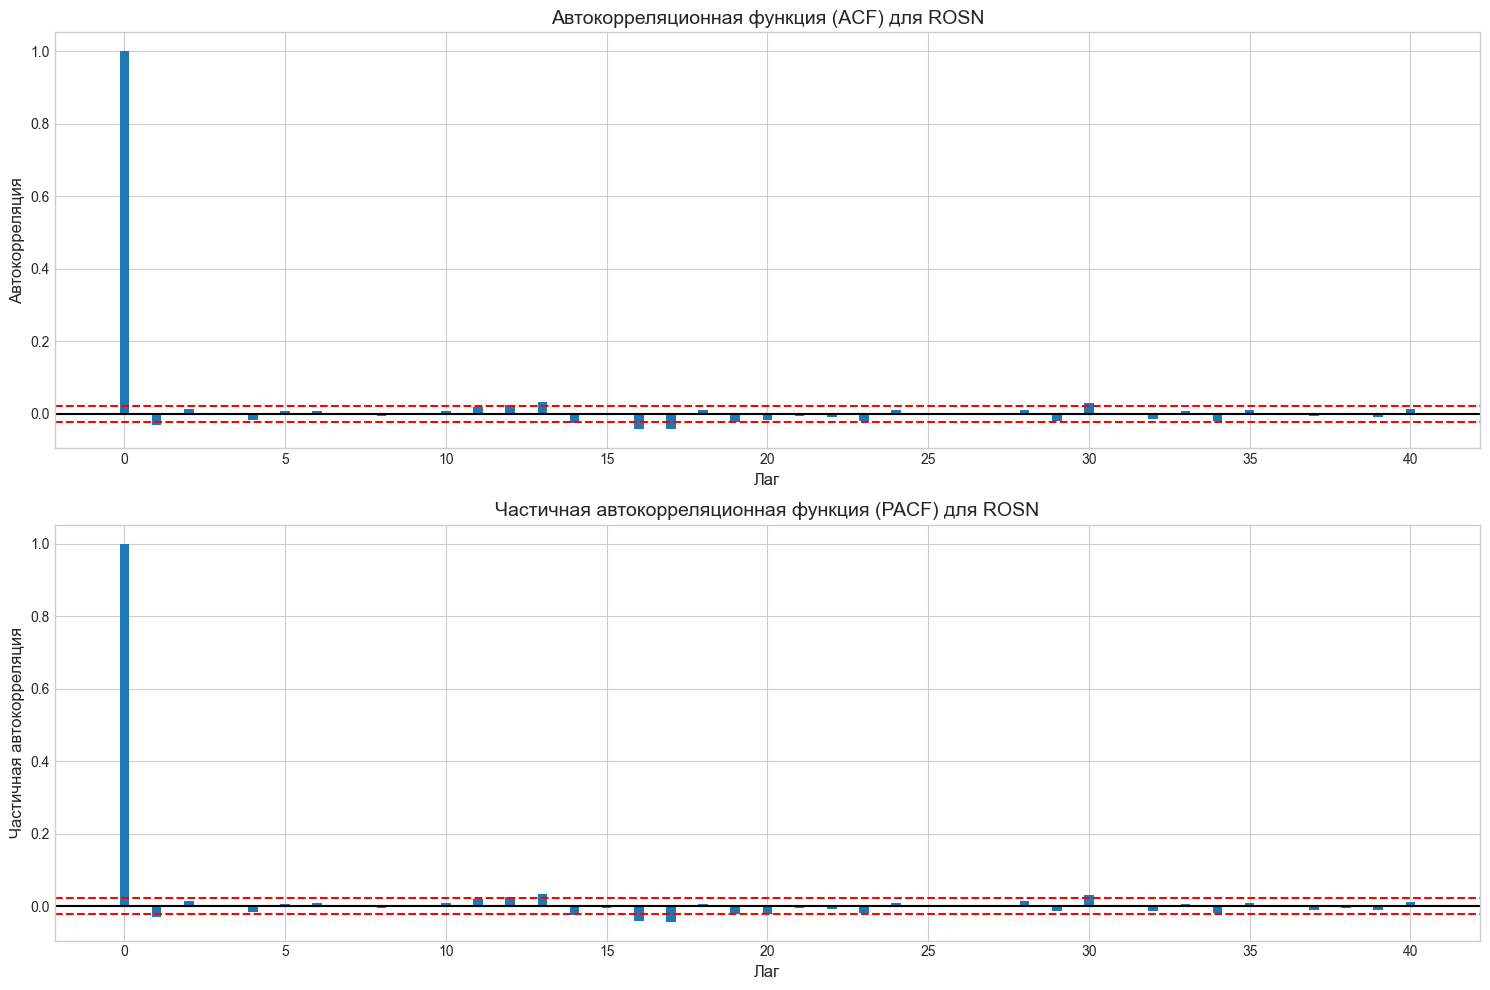

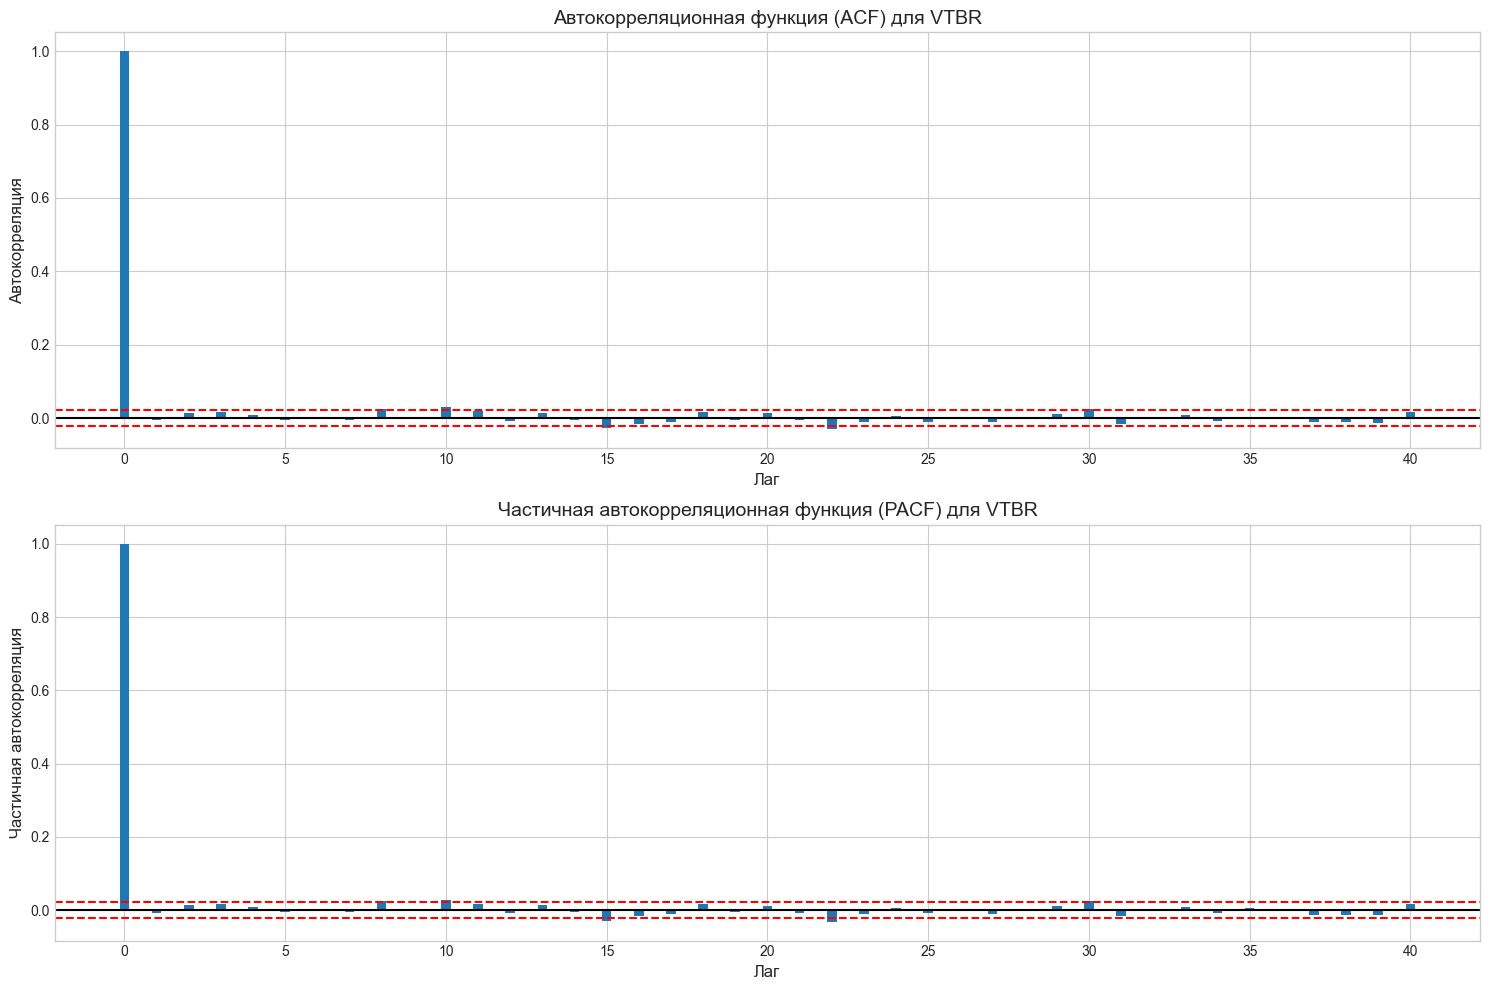

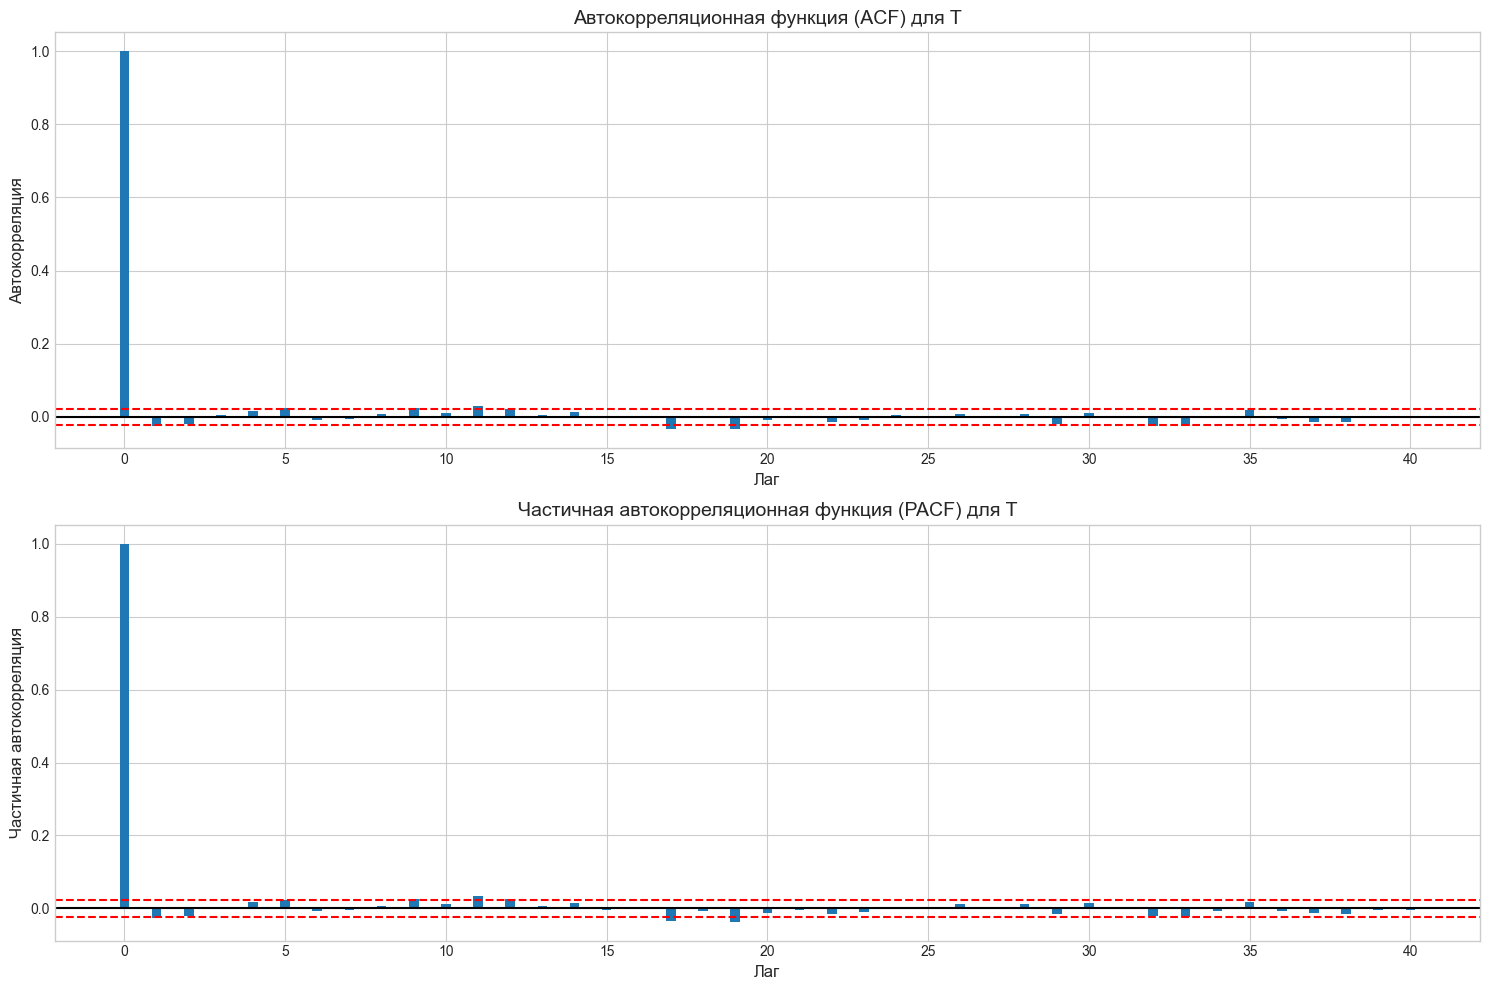

In [18]:
def acf_pacf_analysis(series, company, lags=40):
    """Анализ автокорреляционной и частичной автокорреляционной функций"""
    
    def autocorrelation(x, lag):
        n = len(x)
        mean = np.mean(x)
        
        denom = np.sum((x - mean) ** 2)
        
        numer = 0
        for i in range(lag, n):
            numer += (x[i] - mean) * (x[i - lag] - mean)
        
        return numer / denom
    
    acf_values = [1] 
    for lag in range(1, min(lags + 1, len(series) - 1)):
        acf_values.append(autocorrelation(series, lag))
    
    pacf_values = [1] 
    for lag in range(1, min(lags + 1, len(series) - 1)):
        if lag == 1:
            pacf_values.append(acf_values[1])
        else:
            r = np.array(acf_values[1:lag+1])
            R = np.zeros((lag, lag))
            
            for i in range(lag):
                for j in range(lag):
                    if i >= j:
                        R[i, j] = acf_values[i - j]
                    else:
                        R[i, j] = acf_values[j - i]
            
            try:
                phi = np.linalg.solve(R, r)
                pacf_values.append(phi[-1])
            except np.linalg.LinAlgError:
                phi = np.linalg.pinv(R).dot(r)
                pacf_values.append(phi[-1])
    
    plt.figure(figsize=(15, 10))
    
    plt.subplot(211)
    plt.bar(range(len(acf_values)), acf_values, width=0.3)
    plt.axhline(y=0, linestyle='-', color='black')
    
    conf_interval = 2 / np.sqrt(len(series))
    plt.axhline(y=conf_interval, linestyle='--', color='red')
    plt.axhline(y=-conf_interval, linestyle='--', color='red')
    
    plt.title(f'Автокорреляционная функция (ACF) для {company}', fontsize=14)
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Автокорреляция', fontsize=12)
    plt.grid(True)
    
    plt.subplot(212)
    plt.bar(range(len(pacf_values)), pacf_values, width=0.3)
    plt.axhline(y=0, linestyle='-', color='black')
    
    plt.axhline(y=conf_interval, linestyle='--', color='red')
    plt.axhline(y=-conf_interval, linestyle='--', color='red')
    
    plt.title(f'Частичная автокорреляционная функция (PACF) для {company}', fontsize=14)
    plt.xlabel('Лаг', fontsize=12)
    plt.ylabel('Частичная автокорреляция', fontsize=12)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Интерпретация результатов
    # Если ACF убывает медленно, а PACF обрывается после нескольких лагов,
    # то ряд, скорее всего, имеет авторегрессионную структуру (AR)
    # Если ACF обрывается после нескольких лагов, а PACF убывает медленно,
    # то ряд имеет структуру скользящего среднего (MA)
    # Если оба убывают медленно, то ряд имеет структуру ARMA

for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    prices = company_data['target'].values
    acf_pacf_analysis(prices, company)

Все ряды имеют авторегрессионную структуру. Максимум на лагах - 1 час

Проверим ряды на стационарность

In [19]:
def adf_test(series, company):
    """Проведение расширенного теста Дики-Фуллера"""
    
    def _adf_test(x):
        x_diff = np.diff(x)
        x_lag = x[:-1]
        
        x_lag2 = sm.add_constant(x_lag)
        model = sm.OLS(x_diff, x_lag2)
        results = model.fit()
        
        adf_stat = results.params[1] / results.bse[1]
        
        critical_values = {
            '1%': -3.43,
            '5%': -2.86,
            '10%': -2.57
        }
        
        p_value = stats.norm.sf(adf_stat) 
        
        return adf_stat, p_value, critical_values
    
    adf_stat, p_value, critical_values = _adf_test(series)
    
    print(f'ADF-тест для {company}:')
    print(f'ADF статистика: {adf_stat:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Критические значения:')
    for key, value in critical_values.items():
        print(f'    {key}: {value}')
    
    if p_value < 0.05:
        print('Ряд стационарен (отвергаем нулевую гипотезу о наличии единичного корня)')
    else:
        print('Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)')
    print('----------------------------')


for company in companies:
    company_data = moex_data[moex_data['company'] == company]
    prices = company_data['target'].values
    adf_test(prices, company)

ADF-тест для SBER:
ADF статистика: -91.3468
p-value: 1.0000
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для GAZP:
ADF статистика: -92.5760
p-value: 1.0000
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для LKOH:
ADF статистика: -93.8830
p-value: 1.0000
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для ROSN:
ADF статистика: -93.9480
p-value: 1.0000
Критические значения:
    1%: -3.43
    5%: -2.86
    10%: -2.57
Ряд нестационарен (не можем отвергнуть нулевую гипотезу о наличии единичного корня)
----------------------------
ADF-тест для VTBR:
ADF статистика: -91.4316
p-va

Все ряды нестационарны

## Обучение моделей

### Извлечение признаков

In [20]:
def create_features(df, companies, lookback=5, test_size=0.2):
    """
    Формирование признаков для модели прогнозирования без утечки данных
    
    Параметры:
    df - исходный датафрейм
    companies - список компаний
    lookback - количество предыдущих часов для признаков
    test_size - доля тестовой выборки
    
    Возвращает:
    train_features, test_features - разделенные датафреймы с признаками
    """
    # Сортировка датафрейма по времени
    df = df.sort_values('begin')
    timestamps = df['begin'].unique()
    
    # Разделение временных меток на тренировочные и тестовые
    train_size = int(len(timestamps) * (1 - test_size))
    train_timestamps = timestamps[:train_size]
    test_timestamps = timestamps[train_size:]
    
    # Функция для формирования признаков по заданному набору временных меток
    def extract_features(time_stamps):
        features_list = []
        
        # Учитываем, что для первых lookback временных меток не можем создать признаки
        # Добавляем tqdm для отслеживания прогресса
        for i in tqdm(range(lookback, len(time_stamps)), desc="Extracting features"):
            current_time = pd.Timestamp(time_stamps[i])  # Конвертируем в pandas Timestamp
            
            row_dict = {'target_time': current_time}
            
            # Добавляем признаки на основе временной метки
            row_dict['hour'] = current_time.hour
            row_dict['day_of_week'] = current_time.dayofweek
            row_dict['is_morning'] = 1 if current_time.hour < 13 else 0
            
            for company in companies:
                current_data = df[(df['begin'] == time_stamps[i]) & (df['company'] == company)]
                
                if not current_data.empty:
                    # Целевая переменная - текущая цена закрытия
                    row_dict[f'{company}_target'] = current_data['target'].values[0]
                    
                    # Добавляем предыдущие цены закрытия и открытия (лаги)
                    window_data = []
                    for lag in range(1, lookback + 1):
                        prev_time = time_stamps[i - lag]
                        prev_data = df[(df['begin'] == prev_time) & (df['company'] == company)]
                        
                        if not prev_data.empty:
                            # Предыдущие цены закрытия
                            close_value = prev_data['close'].values[0]
                            window_data.append(close_value)
                            
                            
                    # Добавляем скользящие статистики по последним lookback часам
                    if window_data:
                        # Скользящие статистики
                        row_dict[f'{company}_rolling_mean'] = np.mean(window_data)
                        row_dict[f'{company}_rolling_std'] = np.std(window_data) if len(window_data) > 1 else 0
                        row_dict[f'{company}_rolling_min'] = np.min(window_data)
                        row_dict[f'{company}_rolling_max'] = np.max(window_data)
            
            # Добавляем межкомпанийные признаки (для учета корреляций между компаниями)
                        # Добавляем межкомпанийные признаки (для учета корреляций между компаниями)
            for i, company1 in enumerate(companies):
                for j, company2 in enumerate(companies):
                    if i < j:  # Избегаем дублирования
                        key1_mean = f'{company1}_rolling_mean'
                        key2_mean = f'{company2}_rolling_mean'
                        
                        if key1_mean in row_dict and key2_mean in row_dict:
                            # Разница в средних ценах между компаниями
                            row_dict[f'{company1}_{company2}_mean_price_diff'] = row_dict[key1_mean] - row_dict[key2_mean]
                            
                            # Отношение волатильности
                            std_key1 = f'{company1}_rolling_std'
                            std_key2 = f'{company2}_rolling_std'
                            
                            if std_key1 in row_dict and std_key2 in row_dict and row_dict[std_key2] > 0:
                                row_dict[f'{company1}_{company2}_volatility_ratio'] = row_dict[std_key1] / row_dict[std_key2]
                            
                            # Разница между максимальными и минимальными значениями
                            max_key1 = f'{company1}_rolling_max'
                            max_key2 = f'{company2}_rolling_max'
                            min_key1 = f'{company1}_rolling_min'
                            min_key2 = f'{company2}_rolling_min'
                            
                            if all(k in row_dict for k in [max_key1, max_key2, min_key1, min_key2]):
                                # Разница в диапазонах колебаний
                                range1 = row_dict[max_key1] - row_dict[min_key1]
                                range2 = row_dict[max_key2] - row_dict[min_key2]
                                row_dict[f'{company1}_{company2}_range_diff'] = range1 - range2
                                
                                # Отношение диапазонов
                                if range2 > 0:
                                    row_dict[f'{company1}_{company2}_range_ratio'] = range1 / range2
            
            features_list.append(row_dict)
        
        return pd.DataFrame(features_list)
    
    print("Processing training data...")
    # Для тренировочной выборки используем только тренировочные временные метки
    train_features = extract_features(train_timestamps)
    
    print("Processing test data...")
    # Для тестовой выборки используем последние lookback временных меток
    # из тренировочной выборки и все тестовые временные метки
    test_with_history_timestamps = np.concatenate([train_timestamps[-lookback:], test_timestamps])
    test_features = extract_features(test_with_history_timestamps)
    
    # Удаляем из тестовой выборки строки, которые соответствуют тренировочным данным
    test_features = test_features[test_features['target_time'].isin(test_timestamps)]
    
    return train_features, test_features


from tqdm import tqdm

train_features, test_features = create_features(moex_data, companies, lookback=5, test_size=0.2)

Processing training data...


Extracting features: 100%|██████████| 6646/6646 [09:02<00:00, 12.26it/s]


Processing test data...


Extracting features: 100%|██████████| 1663/1663 [02:17<00:00, 12.13it/s]


In [ ]:
train_features.head()

### Обучим LightGBM для предсказания цен акций

In [ ]:
def train_lightgbm_models(train_features, test_features, companies, params=None):
    """
    Обучение LightGBM моделей для каждой компании
    
    Параметры:
    train_features - тренировочный датафрейм с признаками
    test_features - тестовый датафрейм с признаками
    companies - список компаний
    params - параметры модели LightGBM (опционально)
    
    Возвращает:
    models - словарь с обученными моделями для каждой компании
    predictions - словарь с предсказаниями для тестовой выборки
    metrics - словарь с метриками качества для каждой компании
    """

    
    if params is None:
        params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.01,
    'n_estimators': 1000,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'subsample_freq': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1,
    'bagging_seed': 42,
    'feature_fraction_seed': 42
}
    
    models = {}
    predictions = {}
    metrics = {}
    
    for company in companies:
        target_col = f'{company}_target'
        
        # Проверяем, есть ли целевая переменная для данной компании
        if target_col not in train_features.columns:
            print(f"Целевая переменная {target_col} отсутствует в данных")
            continue
        
        # Отбираем признаки, относящиеся к текущей компании или временные признаки

        feature_cols = [col for col in train_features.columns 
               if (col.startswith(company) or '_' + company + '_' in col or company + '_' in col) 
                  and (col != target_col)
               or col in ['hour', 'day_of_week', 'is_morning']]
        
        # Проверяем, что у нас есть признаки для обучения
        if not feature_cols:
            print(f"Нет признаков для компании {company}")
            continue
        
        # Подготавливаем данные для обучения
        X_train = train_features[feature_cols]
        y_train = train_features[target_col]
        
        X_test = test_features[feature_cols]
        y_test = test_features[target_col]
        
        # Обучаем модель
        model = lgb.LGBMRegressor(**params)
        model.fit(X_train, y_train)
        
        # Делаем предсказания
        y_pred = model.predict(X_test)
        
        # Рассчитываем метрики
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        
        # Сохраняем результаты
        models[company] = model
        predictions[company] = {
            'actual': y_test,
            'predicted': y_pred,
            'timestamps': test_features['target_time']
        }
        metrics[company] = {
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape,
            'R2': r2
            

        }
        
        print(f"Компания: {company}")
        print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape}")
        print("--------------------------------------------------")
    
    return models, predictions, metrics


def visualize_predictions(predictions, companies, n_cols=2):
    """
    Визуализация предсказаний для каждой компании
    
    Параметры:
    predictions - словарь с предсказаниями
    companies - список компаний
    n_cols - количество колонок на графике
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    n_companies = len([c for c in companies if c in predictions])
    n_rows = int(np.ceil(n_companies / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, company in enumerate([c for c in companies if c in predictions]):
        ax = axes[i]
        
        actual = predictions[company]['actual']
        predicted = predictions[company]['predicted']
        timestamps = predictions[company]['timestamps']
        
        ax.plot(timestamps, actual, label='Фактические значения', marker='o', alpha=0.7)
        ax.plot(timestamps, predicted, label='Предсказания', marker='x', linestyle='--')
        
        ax.set_title(f'Предсказания для {company}')
        ax.set_xlabel('Время')
        ax.set_ylabel('Цена закрытия')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Поворачиваем метки времени для лучшей читаемости
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
    # Скрываем пустые подграфики
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def visualize_feature_importance(models, companies, n_cols=2, top_n=15):
    """
    Визуализация важности признаков для каждой компании
    
    Параметры:
    models - словарь с обученными моделями
    companies - список компаний
    n_cols - количество колонок на графике
    top_n - количество наиболее важных признаков для отображения
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    n_companies = len([c for c in companies if c in models])
    n_rows = int(np.ceil(n_companies / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, company in enumerate([c for c in companies if c in models]):
        ax = axes[i]
        model = models[company]
        
        # Получаем важность признаков
        feature_importance = pd.DataFrame({
            'feature': model.feature_name_,
            'importance': model.feature_importances_
        })
        
        # Сортируем по убыванию важности и берем top_n признаков
        feature_importance = feature_importance.sort_values('importance', ascending=False).head(top_n)
        
        # Строим горизонтальный бар-график
        feature_importance.sort_values('importance').plot(
            kind='barh', 
            x='feature', 
            y='importance', 
            legend=False, 
            ax=ax
        )
        
        ax.set_title(f'Важность признаков для {company}')
        ax.set_xlabel('Важность')
        ax.grid(True, alpha=0.3)
        
    # Скрываем пустые подграфики
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

models, predictions, metrics = train_lightgbm_models(train_features, test_features, companies)
visualize_predictions(predictions, companies)
visualize_feature_importance(models, companies)


## Подход 2: более простые признаки + более сложная модель

In [ ]:
moex_data_new = pd.read_parquet('../data/moex_new_features.parquet')

moex_data_new

In [ ]:
moex_data_new.describe()

In [ ]:
moex_data_new['begin'] = pd.to_datetime(moex_data_new['begin'])
moex_data_new['end'] = pd.to_datetime(moex_data_new['end'])

# moex_data_new['date'] = moex_data_new['begin'].dt.date

companies = moex_data_new['company'].unique()


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(15, 8))
for company in companies:
    company_data = moex_data_new[moex_data_new['company'] == company]
    plt.plot(company_data['begin'], company_data['close'], label=company)

plt.title('Динамика цен закрытия по компаниям', fontsize=16)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Цена закрытия', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('prices_by_company.png')
plt.show()

In [ ]:
moex_data_new.columns

In [ ]:
moex_data_new.info()

In [ ]:
for company in companies:
    plt.figure(figsize=(16, 10))
    
    company_data = moex_data_new[moex_data_new['company'] == company]
    plt.plot(company_data['begin'], company_data['value'].rolling(window=30).mean(), label=company)

    plt.title(f'Объём рынка {company} (в рублях)', fontsize=16)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Объём рынка (руб.)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
for company in companies:
    plt.figure(figsize=(15, 8))

    company_data = moex_data_new[moex_data_new['company'] == company]
    plt.plot(company_data['begin'], company_data['volume'].rolling(window=30).mean(), label=company)

    plt.title(f'Объём рынка {company} (в количестве акций)', fontsize=16)
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Объём рынка (шт.)', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Обучение LSTM

In [ ]:
from keras import layers, models
import keras

#### Предобработка данных

In [ ]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler

encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(np.array(moex_data_new['company']).reshape(-1, 1))
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['company']))

df_encoded = pd.concat([moex_data_new, one_hot_df], axis=1)
df_encoded = df_encoded.drop(['company'], axis=1).sort_values('begin')
#для разницы
df_encoded['close'] = df_encoded['close'] - df_encoded['open']


In [ ]:
min(df_encoded['close'])

In [ ]:
df_encoded['day_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['hour_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.hour / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.hour / 24)


In [ ]:
scaler = MinMaxScaler()

df_encoded[['open',  'high', 'low', 'value', 'volume']]\
    = scaler.fit_transform(df_encoded[['open',  'high', 'low', 'value', 'volume']])

df_encoded

In [ ]:
scaler_close = MinMaxScaler()
df_encoded[['close']] = scaler_close.fit_transform(df_encoded[['close']])
df_encoded

In [ ]:
df_encoded

In [ ]:
# train = df_encoded[((df_encoded.begin.dt.year < 2025) & (df_encoded.begin.dt.month < 12)) | ((df_encoded.begin.dt.year != 2024) & (df_encoded.begin.dt.month == 12))]
# validation = df_encoded[((df_encoded.begin.dt.year == 2025) & (df_encoded.begin.dt.month <= 2)) | ((df_encoded.begin.dt.year == 2024) & (df_encoded.begin.dt.month == 12))]
# test = df_encoded[(df_encoded.begin.dt.year == 2025) & (df_encoded.begin.dt.month > 2)]
# print('Train size', len(train))
# print('Validation size', len(validation))
# print('Test size', len(test))

In [ ]:
# batch_size = 32
# length = 60

# # columns = ['close']

# columns = ['close', 'value', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'company_GAZP', 'company_SBER', 'company_LKOH', 'company_ROSN', 'company_T', 'company_VTBR']


In [ ]:
# train = train.filter(columns)
# validation = validation.filter(columns)
# train

In [ ]:
train.columns

In [ ]:
# X_train = []
# y_train = []

# for i in range(len(train) - 60):
#     X_train.append(train.iloc[i:i+60])
#     y_train.append(train.iloc[i+60].close)

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_train.shape

In [ ]:
X_val = []
y_val = []

for i in range(len(validation) - 60):
    X_val.append(validation.iloc[i:i+60])
    y_val.append(validation.iloc[i+60].close)

X_val, y_val = np.array(X_val), np.array(y_val)
X_val.shape

In [ ]:
model = models.Sequential()

#model.add(layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 12)))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units = 50, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units = 50, return_sequences = True))
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(units = 50))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(units = 1))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.Huber())
model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=128)

In [ ]:
test

In [ ]:
test = test.filter(columns)
X_test = []
y_test = []

for i in range(len(test) - 60):
    X_test.append(test.iloc[i:i+60])
    y_test.append(test.iloc[i+60].close)

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape

In [ ]:
y_pred = model.predict(X_test)
y_pred = scaler_close.inverse_transform(y_pred)
y_test = scaler_close.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}, MAPE: {mape}")

In [ ]:
y_pred

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['pred', 'test'])
plt.show()

In [ ]:
def plot_predictions_by_company(test_df, y_test, y_pred, window_size=60, date_column=None):
    """
    Визуализация предсказаний модели с разбивкой по компаниям
    
    Параметры:
    test_df - исходный датафрейм с OHE-компаниями
    y_test - реальные значения (array)
    y_pred - предсказанные значения (array)
    window_size - размер окна, использованного при создании последовательностей
    date_column - название столбца с датами (если None, будет использован индекс)
    """
    # Создаем копию датафрейма без первых window_size строк
    plot_df = test_df.iloc[window_size:].copy()
    plot_df['actual_close'] = y_test
    plot_df['predicted_close'] = y_pred
    print(plot_df.head())
    # Проверяем наличие столбца с датами
    if date_column is None:
        if not isinstance(plot_df.index, pd.DatetimeIndex):
            raise ValueError("Если date_column=None, индекс должен быть DatetimeIndex")
        time_values = plot_df.index
    else:
        if date_column not in plot_df.columns:
            raise KeyError(f"Столбец с датами '{date_column}' не найден в DataFrame")
        time_values = plot_df[date_column]
    
    companies = ['GAZP', 'LKOH', 'ROSN', 'SBER', 'T', 'VTBR']
    n_companies = len(companies)
    
    fig, axes = plt.subplots(n_companies, 1, figsize=(15, 3*n_companies), sharex=True)
    
    for i, company in enumerate(companies):
        # Маска для выборки данных конкретной компании
        mask = plot_df[f'company_{company}'] == 1.0
        
        # Строим график для компании
        axes[i].plot(time_values[mask], plot_df[mask]['actual_close'], 
                    label='Actual', color='blue', alpha=0.7)
        axes[i].plot(time_values[mask], plot_df[mask]['predicted_close'], 
                    label='Predicted', color='red', alpha=0.7, linestyle='--')
        
        axes[i].set_title(f'Company: {company} - Close Price Prediction')
        axes[i].legend()
        axes[i].grid(True)
        
        # Форматирование дат на оси X
        axes[i].xaxis.set_tick_params(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Создаем искусственную временную ось
test['time_index'] = range(len(test))
plot_predictions_by_company(test, y_test, y_pred, window_size=60, date_column='time_index')

In [ ]:
moex_data_new.set_index('begin')

In [ ]:
predictions = pd.DataFrame(y_pred, columns=['predictions'])
df = pd.DataFrame(moex_data_new[(moex_data_new.begin.dt.year == 2025) & (moex_data_new.begin.dt.month > 2)].close).reset_index()
tmp = pd.concat([df, predictions], ignore_index=True, axis=1)
tmp

In [ ]:
tmp.drop(columns=[0], inplace=True)
tmp

In [ ]:
predictions

In [ ]:
train_vis = pd.concat([train, validation], axis=0)
train_vis = scaler_close.inverse_transform(train_vis)
train_vis

In [ ]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
plt.title('Предсказания модели')
plt.ylabel('Цена закрытия (руб.)', fontsize=12)
# plt.plot(train_vis)
plt.plot(tmp[[1, 2]])
plt.legend(['Test', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
y_test.shape, y_pred.shape

In [ ]:
43491 + 5946

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
def create_features(df, companies, lookback=5):
    """
    Формирование признаков для модели прогнозирования с учетом one-hot encoded компаний
    """
    # Сортировка датафрейма по времени
    df = df.sort_values('begin').copy()
    
    # Разделение данных на train, validation и test
    train = df[((df.begin.dt.year < 2025) & (df.begin.dt.month < 12)) | 
               ((df.begin.dt.year == 2024) & (df.begin.dt.month == 12))].copy()
    validation = df[((df.begin.dt.year == 2025) & (df.begin.dt.month <= 2)) | 
                 ((df.begin.dt.year == 2024) & (df.begin.dt.month == 12))].copy()
    test = df[(df.begin.dt.year == 2025) & (df.begin.dt.month > 2)].copy()
    
    print(f'Train size: {len(train)}')
    print(f'Validation size: {len(validation)}')
    print(f'Test size: {len(test)}')
    
    # Функция для формирования признаков
    def extract_features(time_stamps, history_data=None):
        features_list = []
        
        # Если переданы исторические данные, объединяем их с текущими временными метками
        if history_data is not None:
            full_timestamps = np.concatenate([history_data, time_stamps])
            start_idx = len(history_data)
        else:
            full_timestamps = time_stamps
            start_idx = lookback
        
        for i in tqdm(range(start_idx, len(full_timestamps)), desc="Extracting features"):
            current_time = pd.Timestamp(full_timestamps[i])
            
            # Для каждой временной метки обрабатываем каждую компанию ОТДЕЛЬНО
            for company in companies:
                company_col = f'company_{company}'
                company_data = df[(df['begin'] == current_time) & (df[company_col] == 1)]
                
                if company_data.empty:
                    continue
                    
                # Базовые признаки времени
                row_dict = {
                    'target_time': current_time,
                    'company': company,
                    'hour': current_time.hour,
                    'day_of_week': current_time.dayofweek,
                    'is_morning': 1 if current_time.hour < 13 else 0,
                    'day_sin': company_data['day_sin'].values[0],
                    'day_cos': company_data['day_cos'].values[0],
                    'hour_sin': company_data['hour_sin'].values[0],
                    'hour_cos': company_data['hour_cos'].values[0],
                    'close': company_data['close'].values[0]  # Целевая переменная для этой компании
                }
                
                # Собираем исторические данные для скользящих статистик
                window_data = []
                for lag in range(1, lookback + 1):
                    if i - lag >= 0:  # Проверка границ массива
                        prev_time = full_timestamps[i - lag]
                        prev_data = df[(df['begin'] == prev_time) & (df[company_col] == 1)]
                        
                        if not prev_data.empty:
                            window_data.append(prev_data['close'].values[0])
                
                # Добавляем скользящие статистики
                if window_data:
                    row_dict['rolling_mean'] = np.mean(window_data)
                    row_dict['rolling_std'] = np.std(window_data) if len(window_data) > 1 else 0
                    row_dict['rolling_min'] = np.min(window_data)
                    row_dict['rolling_max'] = np.max(window_data)
                    row_dict['rolling_range'] = row_dict['rolling_max'] - row_dict['rolling_min']
                else:
                    # Заполняем нулями, если нет данных
                    row_dict['rolling_mean'] = 0
                    row_dict['rolling_std'] = 0
                    row_dict['rolling_min'] = 0
                    row_dict['rolling_max'] = 0
                    row_dict['rolling_range'] = 0
                
                features_list.append(row_dict)
        
        return pd.DataFrame(features_list)
    
    print("Processing training data...")
    train_features = extract_features(train['begin'].unique())
    
    print("Processing validation data...")
    val_history = train['begin'].unique()[-lookback:]
    val_features = extract_features(validation['begin'].unique(), val_history)
    
    print("Processing test data...")
    test_history = validation['begin'].unique()[-lookback:]
    test_features = extract_features(test['begin'].unique(), test_history)
    
    return train_features, val_features, test_features
# Чтение и подготовка данных
moex_data_new = pd.read_parquet('../data/moex_new_features.parquet')
moex_data_new['begin'] = pd.to_datetime(moex_data_new['begin'])
moex_data_new['end'] = pd.to_datetime(moex_data_new['end'])
companies = moex_data_new['company'].unique()
# One-hot encoding для компаний
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(np.array(moex_data_new['company']).reshape(-1, 1))
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['company']))
df_encoded = pd.concat([moex_data_new, one_hot_df], axis=1)
df_encoded = df_encoded.drop(['company'], axis=1).sort_values('begin')
# Расчет фичей
df_encoded['day_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['hour_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.hour / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.hour / 24)
# Масштабирование данных
scaler = MinMaxScaler()
df_encoded[['open', 'high', 'low', 'value', 'volume']] = scaler.fit_transform(df_encoded[['open', 'high', 'low', 'value', 'volume']])
# Масштабирование целевой переменной
scaler_close = MinMaxScaler()
df_encoded[['close']] = scaler_close.fit_transform(df_encoded[['close']])
# Проверка на бесконечные и NaN значения
df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan)
df_encoded = df_encoded.fillna(0)  # Заполняем нулями или другим подходящим значением
# Генерация фичей
train_features, val_features, test_features = create_features(df_encoded, companies, lookback=5)
# Подготовка данных 
def prepare_sequences(features_df, sequence_length=60):
    """
    Подготовка последовательностей для каждой компании отдельно
    """
    # Выбираем все колонки кроме временных меток и идентификатора компании
    feature_cols = [col for col in features_df.columns 
                   if col not in ['target_time', 'company']]
    
    # Получаем список всех компаний в данных
    all_companies = features_df['company'].unique()
    
    X = []
    y = []
    
    # Для каждой компании создаем свои последовательности
    for company in all_companies:
        company_data = features_df[features_df['company'] == company].sort_values('target_time')
        
        # Проверка на наличие достаточного количества данных
        if len(company_data) <= sequence_length:
            continue
        
        for i in range(len(company_data) - sequence_length):
            # Получаем последовательность фичей
            seq_features = company_data[feature_cols].iloc[i:i+sequence_length].values
            
            # Проверка на наличие NaN или бесконечных значений
            if np.isnan(seq_features).any() or np.isinf(seq_features).any():
                # Заполняем нулями или продолжаем цикл
                seq_features = np.nan_to_num(seq_features, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Получаем целевое значение (close для следующего шага)
            target_value = company_data['close'].iloc[i+sequence_length]
            
            X.append(seq_features)
            y.append(target_value)
    
    return np.array(X), np.array(y)
# Заполнение пропущенных значений
train_features = train_features.fillna(0)
val_features = val_features.fillna(0)
test_features = test_features.fillna(0)
# Подготовка данных
X_train, y_train = prepare_sequences(train_features, sequence_length=60)
X_val, y_val = prepare_sequences(val_features, sequence_length=60)
X_test, y_test = prepare_sequences(test_features, sequence_length=60)
# Проверка на пустые массивы
if len(X_train) == 0 or len(X_val) == 0:
    raise ValueError("Недостаточно данных для обучения или валидации")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

для моделирования разницы

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
def create_features(df, companies, lookback=5):
    """
    Формирование признаков для модели прогнозирования с учетом one-hot encoded компаний
    """
    # Сортировка датафрейма по времени
    df = df.sort_values('begin').copy()
    
    # Разделение данных на train, validation и test
    train = df[((df.begin.dt.year < 2025) & (df.begin.dt.month < 12)) | 
               ((df.begin.dt.year == 2024) & (df.begin.dt.month == 12))].copy()
    validation = df[((df.begin.dt.year == 2025) & (df.begin.dt.month <= 2)) | 
                 ((df.begin.dt.year == 2024) & (df.begin.dt.month == 12))].copy()
    test = df[(df.begin.dt.year == 2025) & (df.begin.dt.month > 2)].copy()
    
    print(f'Train size: {len(train)}')
    print(f'Validation size: {len(validation)}')
    print(f'Test size: {len(test)}')
    
    # Функция для формирования признаков
    def extract_features(time_stamps, history_data=None):
        features_list = []
        
        # Если переданы исторические данные, объединяем их с текущими временными метками
        if history_data is not None:
            full_timestamps = np.concatenate([history_data, time_stamps])
            start_idx = len(history_data)
        else:
            full_timestamps = time_stamps
            start_idx = lookback
        
        for i in tqdm(range(start_idx, len(full_timestamps)), desc="Extracting features"):
            current_time = pd.Timestamp(full_timestamps[i])
            
            # Для каждой временной метки обрабатываем каждую компанию ОТДЕЛЬНО
            for company in companies:
                company_col = f'company_{company}'
                company_data = df[(df['begin'] == current_time) & (df[company_col] == 1)]
                
                if company_data.empty:
                    continue
                    
                # Базовые признаки времени
                row_dict = {
                    'target_time': current_time,
                    'company': company,
                    'hour': current_time.hour,
                    'day_of_week': current_time.dayofweek,
                    'is_morning': 1 if current_time.hour < 13 else 0,
                    'day_sin': company_data['day_sin'].values[0],
                    'day_cos': company_data['day_cos'].values[0],
                    'hour_sin': company_data['hour_sin'].values[0],
                    'hour_cos': company_data['hour_cos'].values[0],
                    'close': company_data['close'].values[0]  # Целевая переменная для этой компании
                }
                
                # Собираем исторические данные для скользящих статистик
                window_data = []
                for lag in range(1, lookback + 1):
                    if i - lag >= 0:  # Проверка границ массива
                        prev_time = full_timestamps[i - lag]
                        prev_data = df[(df['begin'] == prev_time) & (df[company_col] == 1)]
                        
                        if not prev_data.empty:
                            window_data.append(prev_data['close'].values[0])
                
                # Добавляем скользящие статистики
                if window_data:
                    row_dict['rolling_mean'] = np.mean(window_data)
                    row_dict['rolling_std'] = np.std(window_data) if len(window_data) > 1 else 0
                    row_dict['rolling_min'] = np.min(window_data)
                    row_dict['rolling_max'] = np.max(window_data)
                    row_dict['rolling_range'] = row_dict['rolling_max'] - row_dict['rolling_min']
                else:
                    # Заполняем нулями, если нет данных
                    row_dict['rolling_mean'] = 0
                    row_dict['rolling_std'] = 0
                    row_dict['rolling_min'] = 0
                    row_dict['rolling_max'] = 0
                    row_dict['rolling_range'] = 0
                
                features_list.append(row_dict)
        res =  pd.DataFrame(features_list)
        res['close'] = res['close']
        return res
    
    print("Processing training data...")
    train_features = extract_features(train['begin'].unique())
    
    print("Processing validation data...")
    val_history = train['begin'].unique()[-lookback:]
    val_features = extract_features(validation['begin'].unique(), val_history)
    
    print("Processing test data...")
    test_history = validation['begin'].unique()[-lookback:]
    test_features = extract_features(test['begin'].unique(), test_history)
    
    return train_features, val_features, test_features
# Чтение и подготовка данных
moex_data_new = pd.read_parquet('../data/moex_new_features.parquet')
moex_data_new['begin'] = pd.to_datetime(moex_data_new['begin'])
moex_data_new['end'] = pd.to_datetime(moex_data_new['end'])
companies = moex_data_new['company'].unique()
# One-hot encoding для компаний
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(np.array(moex_data_new['company']).reshape(-1, 1))
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(['company']))
df_encoded = pd.concat([moex_data_new, one_hot_df], axis=1)
df_encoded = df_encoded.drop(['company'], axis=1).sort_values('begin')
# Расчет фичей
df_encoded['day_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['day_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.dayofweek / 7)
df_encoded['hour_sin'] = np.sin(2 * np.pi * df_encoded['begin'].dt.hour / 24)
df_encoded['hour_cos'] = np.cos(2 * np.pi * df_encoded['begin'].dt.hour / 24)
df_encoded['close'] = df_encoded['close'] - df_encoded['open']

# Масштабирование данных
scaler = MinMaxScaler()
df_encoded[['open', 'high', 'low', 'value', 'volume']] = scaler.fit_transform(df_encoded[['open', 'high', 'low', 'value', 'volume']])
# Масштабирование целевой переменной
scaler_close = MinMaxScaler()
df_encoded[['close']] = scaler_close.fit_transform(df_encoded[['close']])
# Проверка на бесконечные и NaN значения
df_encoded = df_encoded.replace([np.inf, -np.inf], np.nan)
df_encoded = df_encoded.fillna(0)  # Заполняем нулями или другим подходящим значением
# Генерация фичей
train_features, val_features, test_features = create_features(df_encoded, companies, lookback=5)
# Подготовка данных 
def prepare_sequences(features_df, sequence_length=60):
    """
    Подготовка последовательностей для каждой компании отдельно
    """
    # Выбираем все колонки кроме временных меток и идентификатора компании
    feature_cols = [col for col in features_df.columns 
                   if col not in ['target_time', 'company']]
    
    # Получаем список всех компаний в данных
    all_companies = features_df['company'].unique()
    
    X = []
    y = []
    
    # Для каждой компании создаем свои последовательности
    for company in all_companies:
        company_data = features_df[features_df['company'] == company].sort_values('target_time')
        
        # Проверка на наличие достаточного количества данных
        if len(company_data) <= sequence_length:
            continue
        
        for i in range(len(company_data) - sequence_length):
            # Получаем последовательность фичей
            seq_features = company_data[feature_cols].iloc[i:i+sequence_length].values
            
            # Проверка на наличие NaN или бесконечных значений
            if np.isnan(seq_features).any() or np.isinf(seq_features).any():
                # Заполняем нулями или продолжаем цикл
                seq_features = np.nan_to_num(seq_features, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Получаем целевое значение (close для следующего шага)
            target_value = company_data['close'].iloc[i+sequence_length]
            
            X.append(seq_features)
            y.append(target_value)
    
    return np.array(X), np.array(y)
# Заполнение пропущенных значений
train_features = train_features.fillna(0)
val_features = val_features.fillna(0)
test_features = test_features.fillna(0)
# Подготовка данных
X_train, y_train = prepare_sequences(train_features, sequence_length=60)
X_val, y_val = prepare_sequences(val_features, sequence_length=60)
X_test, y_test = prepare_sequences(test_features, sequence_length=60)
# Проверка на пустые массивы
if len(X_train) == 0 or len(X_val) == 0:
    raise ValueError("Недостаточно данных для обучения или валидации")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
X_train

In [ ]:
import pandas as pd

moex_data_new = pd.read_parquet('../data/moex_new_features.parquet') # Убедитесь, что путь и колонка 'sphere' существуют
moex_data_new

Генерация фичей

In [12]:
import os
# Ensure TF specific env vars are set before TF import
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Filter out INFO and WARNING logs

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
# from tqdm import tqdm # tqdm can be uncommented if progress bar is needed
import traceback

# --- Functions for technical indicators ---
def add_technical_indicators(df_company_group):
    df_company_group = df_company_group.copy()
    # Ensure correct dtypes before calculations
    for col in ['high', 'low', 'close_original', 'open', 'volume_original']: # Added open and volume
        if col in df_company_group.columns:
            df_company_group[col] = pd.to_numeric(df_company_group[col], errors='coerce')

    # Fill NaNs that might prevent diff() or rolling() from working, e.g., at the very start
    # Critical columns for TI calculation
    ti_base_cols = ['open', 'high', 'low', 'close_original', 'volume_original']
    for col in ti_base_cols:
        if col in df_company_group.columns:
            df_company_group[col] = df_company_group[col].ffill().bfill() 
            # If still NaN (e.g. all NaNs in group), fill with 0, though this might be problematic for prices
            # Consider a more robust fill or check for sufficient data earlier
            if df_company_group[col].isnull().all():
                df_company_group[col] = 0 


    delta = df_company_group['close_original'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    
    rs = gain / loss.replace(0, 1e-9) 
    df_company_group['rsi'] = 100 - (100 / (1 + rs))
    df_company_group['rsi'] = df_company_group['rsi'].fillna(50) 

    ema12 = df_company_group['close_original'].ewm(span=12, adjust=False).mean()
    ema26 = df_company_group['close_original'].ewm(span=26, adjust=False).mean()
    df_company_group['macd'] = ema12 - ema26
    df_company_group['macd_signal'] = df_company_group['macd'].ewm(span=9, adjust=False).mean()
    df_company_group['macd_hist'] = df_company_group['macd'] - df_company_group['macd_signal']

    df_company_group['bb_ma'] = df_company_group['close_original'].rolling(window=20, min_periods=1).mean()
    df_company_group['bb_std'] = df_company_group['close_original'].rolling(window=20, min_periods=1).std() # Keep NaNs here for now, fill later
    df_company_group['bb_upper'] = df_company_group['bb_ma'] + (df_company_group['bb_std'] * 2)
    df_company_group['bb_lower'] = df_company_group['bb_ma'] - (df_company_group['bb_std'] * 2)
    df_company_group['bb_width'] = df_company_group['bb_upper'] - df_company_group['bb_lower']
    
    bb_ma_safe = df_company_group['bb_ma'].replace(0, np.nan) 
    df_company_group['price_to_bb_ma'] = (df_company_group['close_original'] / bb_ma_safe).replace([np.inf, -np.inf], np.nan)


    # ATR
    high_low = df_company_group['high'] - df_company_group['low']
    high_cp = np.abs(df_company_group['high'] - df_company_group['close_original'].shift())
    low_cp = np.abs(df_company_group['low'] - df_company_group['close_original'].shift())
    tr = pd.concat([high_low, high_cp, low_cp], axis=1).max(axis=1, skipna=False)
    df_company_group['atr'] = tr.rolling(window=14, min_periods=1).mean()

    # ROC
    n_roc = 14
    roc_denom = df_company_group['close_original'].shift(n_roc).replace(0,np.nan)
    df_company_group[f'roc_{n_roc}'] = ((df_company_group['close_original'].diff(n_roc) / roc_denom) * 100)


    for lag in [1, 2, 3]:
        df_company_group[f'close_original_lag_{lag}'] = df_company_group['close_original'].shift(lag)
        df_company_group[f'volume_original_lag_{lag}'] = df_company_group['volume_original'].shift(lag)

    cols_to_fill_ti = ['rsi', 'macd', 'macd_signal', 'macd_hist', 
                       'bb_ma', 'bb_std', 'bb_upper', 'bb_lower', 'bb_width', 
                       'price_to_bb_ma', 'atr', f'roc_{n_roc}']
    for lag_val in [1, 2, 3]:
        cols_to_fill_ti.append(f'close_original_lag_{lag_val}')
        cols_to_fill_ti.append(f'volume_original_lag_{lag_val}')

    for col in cols_to_fill_ti:
        if col in df_company_group.columns:
            if col == 'price_to_bb_ma': # Special handling for price_to_bb_ma to make it centered around 0
                 df_company_group[col] = df_company_group[col].ffill().bfill().fillna(1.0) - 1.0
            elif col == 'bb_std':
                 df_company_group[col] = df_company_group[col].ffill().bfill().fillna(0) # std can be 0
            else:
                 df_company_group[col] = df_company_group[col].ffill().bfill().fillna(0)
    return df_company_group

# --- Функция create_features_subset ---
def create_features_subset(df_subset_scaled, company_ticker, lookback,
                           history_df_scaled_for_lookback=None):
    features_list = []

    if history_df_scaled_for_lookback is not None and not history_df_scaled_for_lookback.empty:
        history_df_scaled_for_lookback = history_df_scaled_for_lookback.sort_values('begin')
        df_subset_scaled = df_subset_scaled.sort_values('begin')
        
        full_df_for_lookup = pd.concat([history_df_scaled_for_lookback, df_subset_scaled]).drop_duplicates(subset=['begin']).sort_values('begin')
        target_timestamps = np.sort(np.unique(df_subset_scaled['begin'].values))
        iterable_timestamps = np.sort(np.unique(full_df_for_lookup['begin'].values))
        
        start_processing_idx = np.where(iterable_timestamps >= target_timestamps[0])[0][0] if len(target_timestamps) > 0 else len(iterable_timestamps)
    else:
        full_df_for_lookup = df_subset_scaled.copy().sort_values('begin')
        iterable_timestamps = np.sort(np.unique(full_df_for_lookup['begin'].values))
        start_processing_idx = lookback 

    full_df_for_lookup['begin'] = pd.to_datetime(full_df_for_lookup['begin'])

    for i in range(start_processing_idx, len(iterable_timestamps)):
        current_time = pd.Timestamp(iterable_timestamps[i])
        
        if current_time not in df_subset_scaled['begin'].values:
            continue

        company_data_at_time = full_df_for_lookup[full_df_for_lookup['begin'] == current_time]
        if company_data_at_time.empty: continue
        company_data_at_time = company_data_at_time.iloc[[0]]

        row_dict = {
            'target_time': current_time, 'company': company_ticker,
            'hour': current_time.hour, 'day_of_week': current_time.dayofweek,
            'is_morning': 1 if current_time.hour < 13 else 0,
            'day_sin': company_data_at_time['day_sin'].values[0], 'day_cos': company_data_at_time['day_cos'].values[0],
            'hour_sin': company_data_at_time['hour_sin'].values[0], 'hour_cos': company_data_at_time['hour_cos'].values[0],
            'target': company_data_at_time['target'].values[0],
            'open_scaled': company_data_at_time['open'].values[0] if 'open' in company_data_at_time else 0,
            'rsi': company_data_at_time['rsi'].values[0] if 'rsi' in company_data_at_time else 0,
            'macd': company_data_at_time['macd'].values[0] if 'macd' in company_data_at_time else 0,
            'macd_signal': company_data_at_time['macd_signal'].values[0] if 'macd_signal' in company_data_at_time else 0,
            'macd_hist': company_data_at_time['macd_hist'].values[0] if 'macd_hist' in company_data_at_time else 0,
            'bb_width': company_data_at_time['bb_width'].values[0] if 'bb_width' in company_data_at_time else 0,
            'price_to_bb_ma': company_data_at_time['price_to_bb_ma'].values[0] if 'price_to_bb_ma' in company_data_at_time else 0,
            'atr': company_data_at_time['atr'].values[0] if 'atr' in company_data_at_time else 0,
            'roc_14': company_data_at_time['roc_14'].values[0] if 'roc_14' in company_data_at_time else 0,
        }
        for lag_idx in [1,2,3]:
            row_dict[f'close_original_lag_{lag_idx}'] = company_data_at_time[f'close_original_lag_{lag_idx}'].values[0] if f'close_original_lag_{lag_idx}' in company_data_at_time else 0
            row_dict[f'volume_lag_{lag_idx}'] = company_data_at_time[f'volume_original_lag_{lag_idx}'].values[0] if f'volume_original_lag_{lag_idx}' in company_data_at_time else 0

        window_target_values = []
        for lag in range(1, lookback + 1):
            idx_for_lag = i - lag
            if idx_for_lag >= 0:
                prev_time_for_lag = iterable_timestamps[idx_for_lag]
                prev_data_at_time = full_df_for_lookup[full_df_for_lookup['begin'] == prev_time_for_lag]
                if not prev_data_at_time.empty:
                    prev_data_at_time = prev_data_at_time.iloc[[0]]
                    target_val = prev_data_at_time['target'].values[0]
                    window_target_values.append(target_val)
                    if lag <= 3: row_dict[f'target_lag_{lag}'] = target_val

        for lag_idx_fill in range(1, 4):
            if f'target_lag_{lag_idx_fill}' not in row_dict: row_dict[f'target_lag_{lag_idx_fill}'] = 0

        if window_target_values:
            row_dict['target_rolling_mean'] = np.mean(window_target_values)
            row_dict['target_rolling_std'] = np.std(window_target_values) if len(window_target_values) > 1 else 0
        else:
            row_dict['target_rolling_mean'] = 0; row_dict['target_rolling_std'] = 0
        features_list.append(row_dict)
    return pd.DataFrame(features_list)

# --- Функция prepare_sequences ---
def prepare_sequences(features_df, sequence_length=60):
    if features_df is None or features_df.empty:
        return np.array([]), np.array([]), np.array([])
    if 'target_time' in features_df.columns:
        features_df['target_time'] = pd.to_datetime(features_df['target_time'])
        
    feature_cols = [col for col in features_df.columns if col not in ['target_time', 'company', 'target', 'open_scaled']]
    all_companies_in_df = features_df['company'].unique()
    X_list, y_list, open_prices_for_target_list = [], [], []
    for comp_name_ticker in all_companies_in_df:
        company_data = features_df[features_df['company'] == comp_name_ticker].sort_values('target_time')
        if len(company_data) < sequence_length +1 : continue 
        
        current_feature_cols = [f_col for f_col in feature_cols if f_col in company_data.columns]
        if not current_feature_cols: continue
        
        for f_col in current_feature_cols: 
            if not pd.api.types.is_numeric_dtype(company_data[f_col]):
                company_data[f_col] = pd.to_numeric(company_data[f_col], errors='coerce').fillna(0)

        for i in range(len(company_data) - sequence_length):
            seq_features = company_data[current_feature_cols].iloc[i:i+sequence_length].values
            if np.isnan(seq_features).any() or np.isinf(seq_features).any(): 
                seq_features = np.nan_to_num(seq_features, nan=0.0, posinf=0.0, neginf=0.0)
            
            target_value = company_data['target'].iloc[i+sequence_length]
            open_price_val = company_data['open_scaled'].iloc[i+sequence_length] if 'open_scaled' in company_data else 0.0
            X_list.append(seq_features); y_list.append(target_value); open_prices_for_target_list.append(open_price_val)
    return np.array(X_list), np.array(y_list), np.array(open_prices_for_target_list)


# --- Модель LSTM ---
def build_lstm_model(input_shape, model_config_params):
    if input_shape[0] is None or input_shape[0] == 0 or \
       input_shape[1] is None or input_shape[1] == 0:
        raise ValueError(f"Invalid input_shape for model build: {input_shape}. Seq len and num_features must be > 0.")

    inputs_layer = keras.Input(shape=input_shape)
    x = layers.BatchNormalization()(inputs_layer) 

    lstm_units_list = model_config_params.get('lstm_units', [64]) 
    dropout_rate_lstm = model_config_params.get('dropout_rate_lstm', 0.2)
    l2_reg = model_config_params.get('l2_reg', 1e-5)

    for i, units in enumerate(lstm_units_list):
        return_sequences = (i < len(lstm_units_list) - 1) 
        x = layers.LSTM(units, return_sequences=return_sequences,
                        kernel_regularizer=keras.regularizers.l2(l2_reg),
                        recurrent_regularizer=keras.regularizers.l2(l2_reg), 
                        dropout=dropout_rate_lstm 
                        )(x)
        if return_sequences or len(lstm_units_list) == 1 : 
             x = layers.BatchNormalization()(x)

    dense_units = model_config_params.get('dense_units', 32)
    dropout_rate_dense = model_config_params.get('dropout_rate_dense', 0.2)

    x = layers.Dense(dense_units, activation='relu', 
                     kernel_regularizer=keras.regularizers.l2(l2_reg),
                     kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate_dense)(x)

    outputs = layers.Dense(1, activation='linear',
                           kernel_initializer=keras.initializers.GlorotUniform())(x)

    model = keras.Model(inputs=inputs_layer, outputs=outputs)
    return model

def custom_loss(y_true, y_pred):
    return tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)

# --- Функция обучения и оценки модели для КОМПАНИИ ---
def train_and_evaluate_company_model(
    df_company_full_history, company_ticker_name, config
):
    print(f"\n{'='*30} Processing Company: {company_ticker_name} {'='*30}")
    safe_company_name = company_ticker_name.replace(" ", "_").replace("/", "_").replace("*", "_")

    # Initialize default metrics for early exit
    default_metrics = {'mae_diff': np.nan, 'rmse_diff': np.nan, 'r2_diff': np.nan, 'mae_abs': np.nan}


    df_company_full_history = df_company_full_history.sort_values('begin').reset_index(drop=True)
    df_company_full_history['begin'] = pd.to_datetime(df_company_full_history['begin'])
    unique_dates = np.sort(df_company_full_history['begin'].unique())

    min_data_points_for_sequences = config['sequence_length'] + 1 
    min_total_points = (min_data_points_for_sequences + config['lookback']) * 3 
    
    if len(df_company_full_history) < min_total_points:
         print(f"  Not enough data points ({len(df_company_full_history)}, need ~{min_total_points}) for {company_ticker_name}. Skipping.")
         return None, default_metrics

    n_dates = len(unique_dates)
    train_end_idx_date = int(n_dates * config['train_split_ratio']) 
    val_end_idx_date = int(n_dates * (config['train_split_ratio'] + config['val_split_ratio']))


    if train_end_idx_date < config['lookback'] + min_data_points_for_sequences or \
       val_end_idx_date - train_end_idx_date < min_data_points_for_sequences or \
       n_dates - val_end_idx_date < min_data_points_for_sequences :
        print(f"  Cannot create valid train/val/test date splits for {company_ticker_name} (n_dates={n_dates}). Skipping.")
        return None, default_metrics
        
    train_end_date = unique_dates[train_end_idx_date -1]
    val_end_date = unique_dates[val_end_idx_date -1]

    df_train_raw = df_company_full_history[df_company_full_history['begin'] <= train_end_date].copy()
    df_val_raw = df_company_full_history[(df_company_full_history['begin'] > train_end_date) & (df_company_full_history['begin'] <= val_end_date)].copy()
    df_test_raw = df_company_full_history[df_company_full_history['begin'] > val_end_date].copy()

    if df_train_raw.empty or df_val_raw.empty or len(df_train_raw) < min_data_points_for_sequences + config['lookback'] or len(df_val_raw) < min_data_points_for_sequences:
        print(f"  Train or Validation set is too small after date split for {company_ticker_name}. Skipping.")
        return None, default_metrics

    cols_to_scale_main = config['scaler_cols']['main_features'] + \
                         [f'close_original_lag_{i}' for i in range(1,4)] + \
                         [f'volume_original_lag_{i}' for i in range(1,4)]
    cols_to_scale_main = [col for col in cols_to_scale_main if col in df_train_raw.columns]
    
    # Ensure all columns to scale exist and are numeric before proceeding
    for col in cols_to_scale_main:
        if col not in df_train_raw.columns:
            print(f"  FATAL: Column '{col}' for scaling not found in train_raw for {company_ticker_name}. Skipping.")
            return None, default_metrics
        df_train_raw[col] = pd.to_numeric(df_train_raw[col], errors='coerce')
        # Fill NaNs that might have been introduced by pd.to_numeric or were pre-existing AFTER TI
        df_train_raw[col] = df_train_raw[col].ffill().bfill().fillna(0)


    valid_cols_to_scale_final = []
    for col in cols_to_scale_main:
        # Check for NaNs and variance *after* explicit filling for these columns
        temp_col_data = df_train_raw[col] # Already filled
        if temp_col_data.isnull().all() or temp_col_data.nunique() <= 1:
            print(f"  Warning: Column '{col}' in {company_ticker_name} has no variance post-TI/fill for scaling. Excluding.")
        else:
            valid_cols_to_scale_final.append(col)
    
    if not valid_cols_to_scale_final:
        print(f"  No valid columns with variance to scale for main features in {company_ticker_name}. Skipping.")
        return None, default_metrics
    cols_to_scale_main = valid_cols_to_scale_final


    scaler_main_company = MinMaxScaler()
    scaler_target_company = MinMaxScaler()
    
    # Fill NaNs in target_raw before fitting its scaler
    df_train_raw['target_raw'] = pd.to_numeric(df_train_raw['target_raw'], errors='coerce').ffill().bfill().fillna(0)


    try:
        # Fit main scaler
        df_train_raw_to_fit_main = df_train_raw[cols_to_scale_main] # These columns are already filled and checked for variance
        scaler_main_company.fit(df_train_raw_to_fit_main)

        # Fit target scaler
        train_target_for_scaler = df_train_raw[['target_raw']] # Already filled
        if train_target_for_scaler['target_raw'].nunique() <= 1:
            print(f"  Warning: 'target_raw' has no variance in train set for {company_ticker_name} after filling. Skipping.")
            return None, default_metrics
        scaler_target_company.fit(train_target_for_scaler)

    except Exception as e:
        print(f"  Error during scaler fitting for {company_ticker_name}: {e}. Skipping.")
        traceback.print_exc()
        return None, default_metrics

    df_train_scaled, df_val_scaled, df_test_scaled = df_train_raw.copy(), df_val_raw.copy(), df_test_raw.copy()

    for df_part_scaled, df_part_raw in [(df_train_scaled, df_train_raw), (df_val_scaled, df_val_raw), (df_test_scaled, df_test_raw)]:
        if df_part_raw.empty: continue
        
        # Scale main features
        for col in cols_to_scale_main: # Ensure numeric and fill NaNs for val/test before transform
             df_part_raw[col] = pd.to_numeric(df_part_raw[col], errors='coerce').ffill().bfill().fillna(0)
        df_part_scaled[cols_to_scale_main] = scaler_main_company.transform(df_part_raw[cols_to_scale_main])
        
        # Scale target
        df_part_raw['target_raw'] = pd.to_numeric(df_part_raw['target_raw'], errors='coerce').ffill().bfill().fillna(0)
        df_part_scaled['target'] = scaler_target_company.transform(df_part_raw[['target_raw']])


    val_history_len = min(len(df_train_scaled), config['lookback'] + config['sequence_length'])
    val_history_scaled = df_train_scaled.iloc[-val_history_len:] if val_history_len > 0 else pd.DataFrame()
    
    test_history_source = df_val_scaled if not df_val_scaled.empty else df_train_scaled 
    test_history_len = min(len(test_history_source), config['lookback'] + config['sequence_length'])
    test_history_scaled = test_history_source.iloc[-test_history_len:] if test_history_len > 0 else pd.DataFrame()


    train_features_df = create_features_subset(df_train_scaled, company_ticker_name, config['lookback'], history_df_scaled_for_lookback=None)
    val_features_df = pd.DataFrame()
    if not df_val_scaled.empty: val_features_df = create_features_subset(df_val_scaled, company_ticker_name, config['lookback'], history_df_scaled_for_lookback=val_history_scaled)
    test_features_df = pd.DataFrame()
    if not df_test_scaled.empty: test_features_df = create_features_subset(df_test_scaled, company_ticker_name, config['lookback'], history_df_scaled_for_lookback=test_history_scaled)

    if train_features_df.empty or (not df_val_scaled.empty and val_features_df.empty):
        print(f"  Not enough data to create features for train/val for {company_ticker_name}. Skipping.")
        return None, default_metrics

    X_train, y_train, _ = prepare_sequences(train_features_df.fillna(0), sequence_length=config['sequence_length'])
    X_val, y_val, _ = prepare_sequences(val_features_df.fillna(0), sequence_length=config['sequence_length'])

    if len(X_train) == 0 or (not df_val_scaled.empty and len(X_val) == 0):
        print(f"  Not enough data for train/val sequences for {company_ticker_name}. Skipping.")
        return None, default_metrics
    
    current_batch_size = config['training_params']['batch_size']
    if X_train.shape[0] < current_batch_size or (len(X_val) > 0 and X_val.shape[0] < current_batch_size):
        adjusted_batch_size = min(X_train.shape[0], X_val.shape[0] if len(X_val) > 0 else X_train.shape[0])
        if adjusted_batch_size < 1: 
             print(f"  Not enough samples for batch size for {company_ticker_name}. Skipping.")
             return None, default_metrics
        print(f"  Adjusting batch size from {current_batch_size} to {adjusted_batch_size} for {company_ticker_name}.")
        current_batch_size = adjusted_batch_size
        
    if X_train.ndim < 3 or X_train.shape[1] == 0 or X_train.shape[2] == 0 : 
        print(f"  Zero or invalid features/seq_len in X_train for {company_ticker_name} (shape: {X_train.shape}). Skipping.")
        return None, default_metrics
    
    input_shape_model = (X_train.shape[1], X_train.shape[2])
        
    model = build_lstm_model(input_shape_model, config['model_params']) 
    optimizer = keras.optimizers.Adam(learning_rate=config['training_params']['learning_rate'], clipnorm=1.0)
    model.compile(optimizer=optimizer, loss=custom_loss, metrics=['mae', keras.metrics.RootMeanSquaredError(name='rmse')])
    
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=config['training_params']['early_stopping_patience'], restore_best_weights=True, min_delta=0.00005), 
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=config['training_params']['lr_plateau_patience'], min_lr=1e-7, verbose=0, min_delta=0.00005),
        keras.callbacks.TerminateOnNaN()]
    
    y_train = y_train.astype(np.float32)
    y_val = y_val.astype(np.float32) if len(y_val) > 0 else y_val
    
    validation_data_tuple = (X_val, y_val) if len(X_val) > 0 and len(y_val) > 0 else None 

    history = model.fit( X_train, y_train, validation_data=validation_data_tuple,
        epochs=config['training_params']['epochs'], batch_size=current_batch_size,
        callbacks=callbacks, verbose=0, shuffle=True)
    
    val_loss_history = history.history.get('val_loss', [])
    if val_loss_history: last_val_loss_str, best_val_loss_str = f"{val_loss_history[-1]:.4f}", f"{min(val_loss_history):.4f}"
    else: last_val_loss_str, best_val_loss_str = "N/A", "N/A"
    print(f"  Training for {company_ticker_name} done. Last val_loss: {last_val_loss_str}, Best val_loss: {best_val_loss_str}")
    
    if val_loss_history: 
        plt.figure(figsize=(12, 4)); 
        plt.subplot(1, 2, 1); plt.plot(history.history['loss'], label='Train Loss'); plt.plot(history.history['val_loss'], label='Val Loss'); plt.title('Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2); plt.plot(history.history['mae'], label='Train MAE'); plt.plot(history.history['val_mae'], label='Val MAE'); plt.title('MAE'); plt.legend(); plt.grid(True)
        plt.suptitle(f'Training History: {company_ticker_name}'); plt.tight_layout(rect=[0,0,1,0.95]); 
        plt.savefig(f'./plots/training_hist_co_{safe_company_name}.png'); plt.close()

    # --- Test Set Evaluation and Plotting ---
    current_metrics = default_metrics.copy() # Start with default NaNs
    X_test, y_test, open_prices_test_company_scaled = np.array([]), np.array([]), np.array([])
    if test_features_df is not None and not test_features_df.empty:
        X_test, y_test, open_prices_test_company_scaled = prepare_sequences(test_features_df.fillna(0), sequence_length=config['sequence_length'])
        if len(X_test) == 0 : print(f"  Warning: No test sequences for {company_ticker_name}.")
            
    if X_test.size > 0 and len(X_test) > 0 and y_test.size > 0 :
        test_subset_size = min(len(X_test), config['training_params'].get('max_test_samples', len(X_test)))
        X_test_subset, y_test_subset = X_test[:test_subset_size], y_test[:test_subset_size].astype(np.float32)
        open_prices_test_subset_scaled = open_prices_test_company_scaled[:test_subset_size]

        if len(X_test_subset) > 0:
            y_pred_scaled = model.predict(X_test_subset, batch_size=current_batch_size, verbose=0)
            
            if hasattr(scaler_target_company, 'n_features_in_') and scaler_target_company.n_features_in_ > 0:
                y_test_diff_original = scaler_target_company.inverse_transform(y_test_subset.reshape(-1, 1)).flatten()
                y_pred_diff_original = scaler_target_company.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
            else: 
                y_test_diff_original, y_pred_diff_original = y_test_subset.flatten(), y_pred_scaled.flatten()
            
            valid_preds_indices = np.isfinite(y_test_diff_original) & np.isfinite(y_pred_diff_original)
            y_test_diff_original_f = y_test_diff_original[valid_preds_indices]
            y_pred_diff_original_f = y_pred_diff_original[valid_preds_indices]

            if len(y_test_diff_original_f) > 1:
                current_metrics['mae_diff'] = mean_absolute_error(y_test_diff_original_f, y_pred_diff_original_f)
                current_metrics['rmse_diff'] = np.sqrt(mean_squared_error(y_test_diff_original_f, y_pred_diff_original_f))
                current_metrics['r2_diff'] = r2_score(y_test_diff_original_f, y_pred_diff_original_f)
                print(f"    {company_ticker_name} Test Diff (Target): MAE={current_metrics['mae_diff']:.4f}, RMSE={current_metrics['rmse_diff']:.4f}, R2={current_metrics['r2_diff']:.4f} (on {len(y_test_diff_original_f)} samples)")
            else: 
                print(f"    {company_ticker_name} Test Diff: Not enough valid samples for metrics.")

            open_col_idx = -1
            if 'open' in cols_to_scale_main: 
                open_col_idx = cols_to_scale_main.index('open')

            actual_close_abs, predicted_close_abs = np.array([]), np.array([]) 

            if open_col_idx != -1 and \
               hasattr(scaler_main_company, 'n_features_in_') and scaler_main_company.n_features_in_ > 0 and \
               len(y_test_diff_original_f) > 0 and \
               len(open_prices_test_subset_scaled) == len(y_test_subset): 
                
                open_prices_test_subset_scaled_f = open_prices_test_subset_scaled[valid_preds_indices]
                
                dummy_open_scaled = np.zeros((len(open_prices_test_subset_scaled_f), scaler_main_company.n_features_in_))
                dummy_open_scaled[:, open_col_idx] = open_prices_test_subset_scaled_f.flatten()
                
                open_prices_test_original = scaler_main_company.inverse_transform(dummy_open_scaled)[:, open_col_idx]
                
                actual_close_abs = open_prices_test_original + y_test_diff_original_f
                predicted_close_abs = open_prices_test_original + y_pred_diff_original_f
                
                valid_abs_indices = np.isfinite(actual_close_abs) & np.isfinite(predicted_close_abs)
                if np.sum(valid_abs_indices) > 1:
                    current_metrics['mae_abs'] = mean_absolute_error(actual_close_abs[valid_abs_indices], predicted_close_abs[valid_abs_indices])
                    print(f"    {company_ticker_name} Test Abs Close MAE: {current_metrics['mae_abs']:.4f} (on {np.sum(valid_abs_indices)} samples)")
            else:
                print(f"    {company_ticker_name} Skipping absolute price metrics calculation (scaler/data issue).")
            
            os.makedirs('./plots', exist_ok=True) 
            plt.figure(figsize=(15, 5))
            plt.plot(y_test_diff_original_f, label='Actual Target (Close-Open)', alpha=0.7)
            plt.plot(y_pred_diff_original_f, label='Predicted Target (Close-Open)', linestyle='--')
            plt.title(f'{company_ticker_name} - Test Set: Actual vs. Predicted Target (Close-Open)')
            plt.xlabel('Time Step (Test Sample Index)'); plt.ylabel('Price Difference (Target)')
            plt.legend(); plt.grid(True)
            plt.savefig(f'./plots/test_target_timeseries_{safe_company_name}.png'); plt.close()

            if len(actual_close_abs) > 0 and len(predicted_close_abs) > 0 and np.sum(valid_abs_indices) > 0:
                plt.figure(figsize=(15, 5))
                plt.plot(actual_close_abs[valid_abs_indices], label='Actual Close Price', alpha=0.7)
                plt.plot(predicted_close_abs[valid_abs_indices], label='Predicted Close Price', linestyle='--')
                plt.title(f'{company_ticker_name} - Test Set: Actual vs. Predicted Absolute Close Price')
                plt.xlabel('Time Step (Test Sample Index)'); plt.ylabel('Absolute Close Price')
                plt.legend(); plt.grid(True)
                plt.savefig(f'./plots/test_abs_price_timeseries_{safe_company_name}.png'); plt.close()

            if len(y_test_diff_original_f) > 0:
                plt.figure(figsize=(8, 8))
                plt.scatter(y_test_diff_original_f, y_pred_diff_original_f, alpha=0.5, s=10)
                min_val_s = min(np.min(y_test_diff_original_f), np.min(y_pred_diff_original_f))
                max_val_s = max(np.max(y_test_diff_original_f), np.max(y_pred_diff_original_f))
                plt.plot([min_val_s, max_val_s], [min_val_s, max_val_s], 'r--') 
                plt.title(f'{company_ticker_name} - Test: Actual vs. Pred Target (R2: {current_metrics["r2_diff"]:.3f})')
                plt.xlabel('Actual Target (Close-Open)'); plt.ylabel('Predicted Target (Close-Open)')
                plt.grid(True); plt.axis('equal'); plt.tight_layout()
                plt.savefig(f'./plots/test_target_scatter_{safe_company_name}.png'); plt.close()
                
                residuals = y_test_diff_original_f - y_pred_diff_original_f
                plt.figure(figsize=(10, 6))
                plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
                plt.title(f'{company_ticker_name} - Test Set: Histogram of Prediction Residuals (Target)')
                plt.xlabel('Prediction Error (Actual - Predicted)'); plt.ylabel('Frequency')
                plt.grid(True); plt.axvline(residuals.mean(), color='r', linestyle='dashed', linewidth=1, label=f'Mean Error: {residuals.mean():.2f}')
                plt.legend()
                plt.savefig(f'./plots/test_residuals_hist_{safe_company_name}.png'); plt.close()
    else: print(f"  No test data to evaluate for {company_ticker_name}.")

    if hasattr(model, 'save'):
        os.makedirs('./models', exist_ok=True)
        model.save(f'./models/model_co_{safe_company_name}.keras')
    return model, current_metrics

# --- Основной скрипт ---
if __name__ == "__main__":
    tf.config.threading.set_inter_op_parallelism_threads(1) 
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.keras.backend.set_epsilon(1e-7)

    config = { 
        'lookback': 15, 
        'sequence_length': 60,
        'scaler_cols': {
            'main_features': [
                'open', 'high', 'low', 'value', 'volume_original', 
                'rsi', 'macd', 'macd_signal', 'macd_hist', 
                'bb_ma', 'bb_std', 'bb_upper', 'bb_lower', 'bb_width', 'price_to_bb_ma',
                'atr', 'roc_14' 
            ]
        },
        'model_params': { 
            'lstm_units': [100, 50], 
            'dropout_rate_lstm': 0.25, 
            'dense_units': 64,        
            'dropout_rate_dense': 0.3,
            'l2_reg': 1e-5 
        },
        'training_params': {
            'learning_rate': 0.0005, 
            'epochs': 10,          
            'batch_size': 32, 
            'early_stopping_patience': 15, 
            'lr_plateau_patience': 7,      
            'max_test_samples': 5000 
        },
        'train_split_ratio': 0.70, 
        'val_split_ratio': 0.15   
    }
    os.makedirs('./plots', exist_ok=True)
    os.makedirs('./models', exist_ok=True)

    try: 
        file_path = '../data/moex_new_features.parquet' 
        if not os.path.exists(file_path):
            print(f"Warning: File {file_path} not found. Creating dummy data for testing.")
            dates = pd.to_datetime(pd.date_range(start='2019-01-01', end='2023-06-01', freq='BH')) 
            companies = ['GAZP', 'SBER', 'LKOH', 'ROSN'] 
            data_list = []
            for company in companies:
                base_price = np.random.uniform(50, 400); daily_volatility = base_price * 0.025 
                price_trend = np.random.choice([-0.0005, 0, 0.0005]) 
                for date_obj in dates:
                    base_price *= (1 + price_trend + np.random.normal(0, 0.001)) 
                    base_price = max(10.0, base_price) 
                    
                    open_price_day = max(1.0, base_price + np.random.normal(0, daily_volatility * 0.3))
                    price_swing = np.random.normal(0, daily_volatility * 1.2) 
                    close_price_day = max(1.0, open_price_day + price_swing )
                    
                    high_price_day = max(open_price_day, close_price_day) + np.random.uniform(0, daily_volatility * 0.6)
                    low_price_day = min(open_price_day, close_price_day) - np.random.uniform(0, daily_volatility * 0.6)
                    low_price_day = max(0.5, low_price_day); high_price_day = max(high_price_day, low_price_day + 0.1)
                    
                    volume_day = np.random.randint(300000, 3000000); 
                    
                    for hour in [10, 11, 12, 13, 14, 15, 16, 17, 18]: 
                        center_price = open_price_day + (close_price_day - open_price_day) * ((hour - 10 + 0.5) / 9) 
                        hourly_noise_scale = daily_volatility * 0.15
                        h_open = max(0.1, center_price + np.random.normal(0, hourly_noise_scale))
                        h_close = max(0.1, h_open + np.random.normal(0, hourly_noise_scale * 1.8)) 
                        h_high = max(h_open, h_close) + np.random.uniform(0, hourly_noise_scale * 1.2)
                        h_low = min(h_open, h_close) - np.random.uniform(0, hourly_noise_scale * 1.2)
                        h_low = max(0.05, h_low); h_high = max(h_high, h_low + 0.01)
                        
                        h_volume_part = volume_day / 9 
                        h_volume = max(0, int(h_volume_part + np.random.normal(0, h_volume_part * 0.4)))
                        h_value = ((h_low + h_high) / 2) * h_volume
                        data_list.append({'begin': pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour),
                                          'end': pd.Timestamp(date_obj.year, date_obj.month, date_obj.day, hour, 59, 59),
                                          'open': h_open, 'high': h_high, 'low': h_low, 'close': h_close,
                                          'volume': h_volume, 'value': h_value, 'company': company})
            moex_data_new = pd.DataFrame(data_list)
            if moex_data_new.empty: print("Error: Dummy data creation failed."); exit()
            print(f"Generated dummy data with {len(moex_data_new)} rows for {len(companies)} companies.")
        else: moex_data_new = pd.read_parquet(file_path)
    except Exception as e: print(f"Error loading/creating data: {e}"); traceback.print_exc(); exit()
    
    moex_data_new['begin'] = pd.to_datetime(moex_data_new['begin'])
    moex_data_new['end'] = pd.to_datetime(moex_data_new.get('end', moex_data_new['begin'] + pd.Timedelta(hours=1) - pd.Timedelta(seconds=1)))
    moex_data_new['close_original'] = pd.to_numeric(moex_data_new['close'], errors='coerce') # Ensure numeric
    moex_data_new['volume_original'] = pd.to_numeric(moex_data_new.get('volume', 0), errors='coerce').fillna(0) # Ensure numeric, default 0
    moex_data_new['value'] = pd.to_numeric(moex_data_new.get('value', 0), errors='coerce').fillna(0) # Ensure numeric, default 0
    moex_data_new['open'] = pd.to_numeric(moex_data_new['open'], errors='coerce') # Ensure numeric
    moex_data_new['high'] = pd.to_numeric(moex_data_new['high'], errors='coerce') # Ensure numeric
    moex_data_new['low'] = pd.to_numeric(moex_data_new['low'], errors='coerce')   # Ensure numeric

    # Initial fill for base columns before TI calculation, critical for diff etc.
    base_cols_fill = ['open','high','low','close_original','volume_original','value']
    for col in base_cols_fill:
        if col in moex_data_new.columns:
             moex_data_new[col] = moex_data_new.groupby('company', group_keys=False)[col].apply(lambda x: x.ffill().bfill()) # REMOVED include_groups
             moex_data_new[col] = moex_data_new[col].fillna(0) # Fill any remaining NaNs (e.g. whole group was NaN)


    print("Adding technical indicators (per company)...")
    df_processed = moex_data_new.groupby('company', group_keys=False).apply(add_technical_indicators) # REMOVED include_groups
    df_processed = df_processed.sort_values(['company', 'begin']).reset_index(drop=True)

    df_processed['target_raw'] = df_processed['close_original'] - df_processed['open']
    df_processed['day_sin'] = np.sin(2 * np.pi * df_processed['begin'].dt.dayofweek / 6) 
    df_processed['day_cos'] = np.cos(2 * np.pi * df_processed['begin'].dt.dayofweek / 6)
    df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['begin'].dt.hour / 23) 
    df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['begin'].dt.hour / 23)
    
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
    critical_cols_post_ti = ['open', 'high', 'low', 'close_original', 'volume_original', 'value', 'target_raw']
    # Also include all TI columns that will be scaled
    critical_cols_post_ti.extend(config['scaler_cols']['main_features'])
    critical_cols_post_ti.extend([f'close_original_lag_{i}' for i in range(1,4)])
    critical_cols_post_ti.extend([f'volume_original_lag_{i}' for i in range(1,4)])
    critical_cols_post_ti = list(set(critical_cols_post_ti)) # Unique columns

    for col_fill in critical_cols_post_ti:
        if col_fill in df_processed.columns:
            df_processed[col_fill] = pd.to_numeric(df_processed[col_fill], errors='coerce') # Ensure numeric
            if df_processed[col_fill].isnull().any():
                df_processed[col_fill] = df_processed.groupby('company', group_keys=False)[col_fill].apply( # REMOVED include_groups
                    lambda x: x.ffill().bfill()
                )
            df_processed[col_fill] = df_processed[col_fill].fillna(0) # Final fill with 0


    all_companies_tickers = sorted(list(df_processed['company'].unique()))
    trained_models_summary = {}

    company_iterator = all_companies_tickers
    if 'tqdm' in globals() and callable(globals().get('tqdm')): 
        try:
            from tqdm import tqdm 
            company_iterator = tqdm(all_companies_tickers, desc="Processing Companies")
        except ImportError: pass

    for company_ticker_iter in company_iterator:
        tf.keras.backend.clear_session() 
        df_company_current_iter = df_processed[df_processed['company'] == company_ticker_iter].copy()
        
        # Stricter check for sufficient data before calling train_and_evaluate
        if df_company_current_iter.empty or len(df_company_current_iter) < (config['lookback'] + config['sequence_length'] + config['training_params']['batch_size']) * 2: # More robust check
            print(f"No data or insufficient data for company: {company_ticker_iter} (rows: {len(df_company_current_iter)}). Skipping.")
            trained_models_summary[company_ticker_iter] = {"status": "No/Insufficient Data", 'mae_diff': np.nan, 'rmse_diff': np.nan, 'r2_diff': np.nan, 'mae_abs': np.nan}
            continue
        try:
            # Now train_and_evaluate_company_model returns a tuple (model, metrics) or (None, default_metrics)
            result = train_and_evaluate_company_model(df_company_current_iter, company_ticker_iter, config)
            
            if result is not None:
                model_trained, metrics = result
                if model_trained:
                    trained_models_summary[company_ticker_iter] = {"status": "Success", **metrics}
                else: # Model training failed/skipped inside the function but didn't raise an exception
                    trained_models_summary[company_ticker_iter] = {"status": "Failed/Skipped In Function", **metrics} # metrics would be default_metrics
            else: # Should not happen if train_and_evaluate always returns a tuple, but as a safeguard
                 trained_models_summary[company_ticker_iter] = {"status": "Function Returned None", 'mae_diff': np.nan, 'rmse_diff': np.nan, 'r2_diff': np.nan, 'mae_abs': np.nan}

        except Exception as e:
            print(f"!!! ERROR processing company {company_ticker_iter}: {type(e).__name__} - {str(e)} !!!")
            traceback.print_exc() 
            trained_models_summary[company_ticker_iter] = {"status": f"Error: {type(e).__name__}",
                                                          'mae_diff': np.nan, 'rmse_diff': np.nan, 
                                                          'r2_diff': np.nan, 'mae_abs': np.nan}
            
    print("\n--- Training Summary (Per Company) ---")
    summary_df_list = []
    for company_name_sum, data_sum in trained_models_summary.items():
        row = {'Company': company_name_sum, 'Status': data_sum['status'],
               'Test R2 (Diff)': data_sum.get('r2_diff', np.nan),
               'Test MAE (Diff)': data_sum.get('mae_diff', np.nan),
               'Test RMSE (Diff)': data_sum.get('rmse_diff', np.nan),
               'Test MAE (Abs Close)': data_sum.get('mae_abs', np.nan)}
        summary_df_list.append(row)
    
    summary_df = pd.DataFrame(summary_df_list)
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    print(summary_df)
    summary_df.to_csv('training_summary.csv', index=False)
    print("\nSummary saved to training_summary.csv")

Adding technical indicators (per company)...


/tmp/ipykernel_2548295/3655785301.py:633: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = moex_data_new.groupby('company', group_keys=False).apply(add_technical_indicators) # REMOVED include_groups



============================== Processing Company: GAZP ==============================
  Training for GAZP done. Last val_loss: 0.0074, Best val_loss: 0.0073
    GAZP Test Diff (Target): MAE=0.6148, RMSE=0.9285, R2=-0.1382 (on 1222 samples)
    GAZP Test Abs Close MAE: 0.6148 (on 1222 samples)

============================== Processing Company: LKOH ==============================
  Training for LKOH done. Last val_loss: 0.0055, Best val_loss: 0.0055
    LKOH Test Diff (Target): MAE=19.6344, RMSE=30.1343, R2=-0.1218 (on 1222 samples)
    LKOH Test Abs Close MAE: 19.6344 (on 1222 samples)

============================== Processing Company: ROSN ==============================
  Training for ROSN done. Last val_loss: 0.0061, Best val_loss: 0.0061
    ROSN Test Diff (Target): MAE=1.8536, RMSE=2.9787, R2=-0.0354 (on 1222 samples)
    ROSN Test Abs Close MAE: 1.8536 (on 1222 samples)

============================== Processing Company: SBER ==============================
  Training for SBER d

Учим трансформер